## Загрузка необходимых библиотек

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    MinMaxScaler, 
)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score,
    make_scorer,
    fbeta_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    matthews_corrcoef
)

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as FunctionTransformer
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif, SelectFromModel


from sklearn.base import BaseEstimator, TransformerMixin


import joblib

## Настройки визуализации графиков и настройка вывода датасетов

In [2]:
pd.set_option('display.max_columns', None)  # Все столбцы
# pd.set_option('display.max_colwidth', None) # Максимальная длина столбца
pd.set_option('display.precision', 4) # Число знаков после запятой

## Константы

In [3]:
RANDOM_STATE = 42

## Загрузка и первичный осмотр данных

### Загрузка и первичный осмотр тренировочной выборки 

In [4]:
def load_data(filename, sep=',', decimal=','):
    # Пробуем разные пути к файлу
    file_paths = [
        f'/data/{filename}',  # Абсолютный путь
        f'data/{filename}',   # Относительный путь
        f'../data/{filename}',  # На случай если скрипт в подпапке
        f'{filename}'  # На случай если скрипт в папке с данными
    ]
    
    for path in file_paths:
        if os.path.exists(path):
            try:
                df = pd.read_csv(path,
                                 sep=sep,
                                 decimal=decimal,
                                 encoding='utf-8')
                print(f'Файл успешно загружен из: {path}')
                return df
            except Exception as e:
                print(f"Ошибка при загрузке файла {path}: {e}")
                continue
    
    # Если ни один файл не найден
    raise FileNotFoundError(f'Не удалось найти файл {filename} ни по одному из путей: ' + ', '.join(file_paths))


In [5]:
def separator(n=60):
    print('='*n)

In [6]:
def show_data(df, n_separator=60):
    
    def separator(n_sep=n_separator):
        print('='*n_sep)

    separator()
    print('\nОбщая информация о датасете')
    separator()
    print(f'Количество строк: {df.shape[0]}')
    print(f'Количество столбцов: {df.shape[1]}')
    
    print('\nИнформация о столбцах:')
    separator()
    print(df.info())
    
    print('\nПервые 5 строк датасета:')
    separator()
    display(df.head().style) 

In [7]:
try:
    data_train = load_data('heart_train.csv', decimal='.')
    show_data(data_train)
except Exception as e:
    print(f'Ошибка {e}')



Файл успешно загружен из: data/heart_train.csv

Общая информация о датасете
Количество строк: 8685
Количество столбцов: 28

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 1

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.000000,1.000000,1.000000,1.000000,1.000000,0.535505,1,1.000000,0.000000,8.000000,0.225704,0.105948,0.459176,0.979221,3.000000,0.333333,0.000000,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.000000,1.000000,0.000000,0.000000,1.000000,0.068690,2,1.000000,0.000000,9.000000,0.289923,0.164217,0.117053,0.515584,3.000000,0.833333,0.000000,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.000000,0.000000,1.000000,1.000000,1.000000,0.944001,2,1.000000,1.000000,6.000000,0.550133,0.598745,0.373574,0.012987,2.000000,1.000000,0.000000,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.000000,0.000000,1.000000,0.000000,1.000000,0.697023,0,0.000000,1.000000,3.000000,0.330962,0.077605,0.049735,0.131169,0.000000,0.333333,1.000000,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.000000,0.000000,1.000000,0.000000,1.000000,0.412878,1,0.000000,0.000000,8.000000,0.524600,0.341960,0.830405,0.070130,5.000000,1.000000,1.000000,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [8]:
data_train.head(5)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.3596,0.7321,0.0742,1.0,1.0,1.0,1.0,1.0,0.5355,1,1.0,0.0,8.0,0.2257,0.1059,0.4592,0.9792,3.0,0.3333,0.0,0.2270,0.0482,0.0365,Male,0.2129,0.7093,2664
1,1,0.2022,0.3250,0.0477,1.0,1.0,0.0,0.0,1.0,0.0687,2,1.0,0.0,9.0,0.2899,0.1642,0.1171,0.5156,3.0,0.8333,0.0,0.1502,0.0176,0.0002,Female,0.4129,0.5698,9287
2,2,0.6067,0.8607,0.0559,1.0,0.0,1.0,1.0,1.0,0.9440,2,1.0,1.0,6.0,0.5501,0.5987,0.3736,0.0130,2.0,1.0000,0.0,0.2270,0.0482,0.0365,Female,0.2387,0.2209,5379
3,3,0.7303,0.0071,0.0532,0.0,0.0,1.0,0.0,1.0,0.6970,0,0.0,1.0,3.0,0.3310,0.0776,0.0497,0.1312,0.0,0.3333,1.0,0.2270,0.0482,0.0365,Female,0.3484,0.2674,8222
4,4,0.7753,0.7571,0.0220,0.0,0.0,1.0,0.0,1.0,0.4129,1,0.0,0.0,8.0,0.5246,0.3420,0.8304,0.0701,5.0,1.0000,1.0,0.2270,0.0482,0.0365,Male,0.6194,0.4419,4047


In [9]:
data_train.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.0000,8685.0000,8685.0000,8685.0000,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000,8685.0000,8685.0000,8442.0000,8442.0000,8442.0000,8685.0000,8685.0000,8685.0000,8685.0000,8442.0000,8685.0000,8685.0000,8685.0000,8685.0000,8685.0000,8685.0000,8685.0000,8685.0000
mean,4342.0000,0.4500,0.5011,0.0507,0.6521,0.4896,0.9029,0.4983,0.6020,0.5034,1.0575,0.4954,0.5012,5.4934,0.4992,0.4961,0.4968,0.5055,3.5083,0.5037,0.3469,0.2273,0.0482,0.0367,0.4503,0.4976,4831.2108
std,2507.2879,0.2312,0.2847,0.0235,0.4763,0.4999,0.2962,0.5000,0.4895,0.2848,0.8666,0.5000,0.5000,2.8679,0.2853,0.2847,0.2826,0.2863,2.2818,0.3281,0.4760,0.0766,0.0755,0.0602,0.1702,0.1718,2782.5856
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,2171.0000,0.2584,0.2679,0.0348,0.0000,0.0000,1.0000,0.0000,0.0000,0.2633,0.0000,0.0000,0.0000,3.0000,0.2559,0.2519,0.2542,0.2636,2.0000,0.1667,0.0000,0.2270,0.0482,0.0365,0.3032,0.3488,2425.0000
50%,4342.0000,0.4607,0.4998,0.0504,1.0000,0.0000,1.0000,0.0000,1.0000,0.5021,1.0000,0.0000,1.0000,5.0000,0.4999,0.4949,0.4948,0.5036,3.0000,0.5000,0.0000,0.2270,0.0482,0.0365,0.4452,0.5000,4837.0000
75%,6513.0000,0.6404,0.7464,0.0660,1.0000,1.0000,1.0000,1.0000,1.0000,0.7487,2.0000,1.0000,1.0000,8.0000,0.7446,0.7410,0.7370,0.7506,6.0000,0.8333,1.0000,0.2270,0.0482,0.0365,0.6000,0.6512,7242.0000
max,8684.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,3.0000,1.0000,1.0000,10.0000,1.0000,1.0000,1.0000,1.0000,7.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9650.0000


In [10]:
data_train['Unnamed: 0'].nunique()

8685

In [11]:
data_train['Diabetes'].value_counts()

Diabetes
1.0    5505
0.0    2937
Name: count, dtype: int64

### Содержание столбцов

---

**Важное примечание**

Многие числовые признаки (`Age`, `Cholesterol`, `Heart Rate` и пр.) уже подвергнуты min-max нормализации и представлены значениями в диапазоне [0; 1], где 0 и 1 соответствуют минимальному и максимальному исходному значению в данных.
 

**Содержание столбцов**

1.  **`Unnamed: 0`** - Безимянный столбец содержит последовательные целые числа от 0 до 8684. Данные похожи на номер записи (строки). Не несут ценности для модели. Необходимо удалить.

2. **`Age`** судя по названию должен содержиать возраст пациента. Данные были масштабированы


3.  **`Cholesterol`** - Количестве холестерина в крови пациента. 
Оптимальное значение концентрации общего холестерина в плазме крови — менее 5,2 ммоль/л. стоило ожидать данные в виде рациональных чисел от 0,5 до 7 и более но видимо данные были масштабированы 

4. **`Heart rate`** - ЧСС, Частота сердечных сокращений. Данные масштабированы 

5. **`Diabetes`** Наличие диабета  (без указани типа) в виде бинарного числового значения.
  Возможные значения:
    - 0 — заболевание отсутствует
    - 1 — заболевание подтверждено.

6. **`Family History`** - Наследственная предрасположенность (не указано к какому заболеванию предположительно к сердечным заболеваниям). Содержит данные в виде числового бинарного значения.
Возможные значения
    - 0 — наследственность заболевания отсутствует
    - 1 — Наследственность заболевания есть.

7. **`Smoking`** - Курение. Данные в виде числового бинарного значения:
    - 0 — Не курит
    - 1 — Курит.

8. **`Obesity`** -  наличие ожирения. Данные в виде числового бинарного значения:
    - 0 — Ожирения нет
    - 1 — Ожирение есть.

9.  **`Alcohol Consumption`** - Употребления алкоголя пациентом. Данные в виде числового бинарного значения:
    - 0 — Не употребляет
    - 1 — Употребляет.

10. **`Exercise Hours Per Week`** - Часы физических упражнений в неделю  у пациента.  Данные масштабированы 

11. **`Diet`** - Тип соблюдаемой диеты. Содержит категориальные данные в виде целых числовых значений от 0 до 3 определяющие тип ограничения.

    **Например:**
  - 0 — не соблюдает диету / обычное питание;
  - 1 — лёгкое ограничение (например, снижение сахара);
  - 2 — умеренная диета (например, низкоуглеводная);
  - 3 — строгая диета (например, кето, безглютеновая, лечебная).

12. **`Previous Heart Problems`** - Наличие сердечных заболеваний. Данные в виде числового бинарного значения:
    - 0 — Проблем с сердцем не было
    - 1 — Проблемы с сердцем были

13. **`Medication Use`** - Приём лекарств. Данные в виде числового бинарного значения:
    - 0 — Не принимает лекарства
    - 1 — Принимает лекарства
    

14. **`Stress Leve`** - Уровень стресса. Категориальные данные в виде целых числовых значений от 1 до 10 определяющие тип ограничения питания.

15. **`Sedentary Hours Per Day`** -  количество часов сидячего образа жизни в день. Данные масштабированы

16. **`Income`** - доход пациента. Данные масштабированы

17. **`BMI`** - индекс массы тела пациента. Данные масштабированы


18. **`Triglycerides`** - содержание Триглицеридов -  это сложные эфиры жирных кислот и глицерина, основная форма хранения жиров в организме. Они являются главным источником энергии для клеток.оценить риск развития атеросклероза, сердечно-сосудистых заболеваний и острого панкреатита. Повышение уровня триглицеридов в крови (гипертриглицеридемия) — независимый фактор риска атеросклероза. Особенно опасно сочетание высокого уровня триглицеридов с низким уровнем «хорошего» холестерина (ЛПВП). Данные масштабированы.

19. **`Physical Activity Days Per Week`** - Количество дней активности в неделю. Категориальные данные в виде целых числовых значений от 0 до 7.

20. **`Sleep Hours Per Day`**  - Количество часов сна в день. Данные масштабированы.

21. **`Heart Attack Risk (Binary)`** Риск поражения сердца (Целевая переменная). В виде числового бинарного значения:
    - 0 — Риска нет
    - 1 — Риск есть

22. **`Blood sugar`** - Содержание сахара в крови. Данные масштабированы.

23. **`CK-MB`** -  в биохимическом анализе крови — креатинкиназа-МВ (креатинфосфокиназа-МВ, КК-МВ, КФК-МВ) — изофермент креатинкиназы, характерный для сердечной мышцы (миокарда). В норме в крови этот фермент присутствует в незначительных количествах, но при повреждении миокарда его активность возрастает. Данные масштабированы.
**Критическая утечка данных** - Прямой лабораторный маркер, который измеряется при подозрении на острые сердечные события. Необходимо удалить


24. **`Troponin`** - Анализ крови на тропонин — это исследование, которое определяет концентрацию белка тропонина I — маркёра повреждения сердечной мышцы. У здорового человека тропонин изолирован и в кровь не попадает. Резкое увеличение его содержания в крови указывает на разрушение мышечных клеток и высвобождение белка. Данные масштабированы..
**Критическая утечка данных** - Прямой лабораторный маркер, биохимическая  диагностика инфаркта миокарда. Необходимо удалить.

25. **`Gender`** - Пол. Бинарный признак.

26. 27.   **`Systolic blood pressure`** и **`Diastolic blood pressure`** - систолическое и диастолическое давление. Данные в столбцах представлены в виде рациональных чисел из диапазона [0; 1] и можно сделать вывод о нормализации этих значений с использованием min-max нормализации так как есть четкие значения 0 и 1.

28. **`id`** - идентификатор пациента. Данные в столбцах представлены в виде целых натуральных чисел из диапазона от 1 до 9650. Не несет прогнозной силы для новых пациентов. Необходимо удалить перед обучением модели.





### Выводы по результатам первичного осмотра датасета

---

 1. **Общая характеристика данных**
- **Объём**: 8 685 записей о пациентах, 28 признаков
- **Целевая переменная**: `Heart Attack Risk (Binary)` (бинарный признак риска сердечного приступа)
- **Полнота данных**: Хорошая - большинство столбцов не содержат пропусков

2. **Пропущенные значения в 243 записях** \
Отсутствуют данные в 9 столбцах для одинакового количества записей (243):
- `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`
- `Previous Heart Problems`, `Medication Use`, `Stress Level`, `Physical Activity Days Per Week`

3. **Несоответствие типов данных** \
 Бинарные признаки такие как `Diabetes`, `Smoking` и другие, имеют тип данных `float64`, хотя логичнее использовать `int8` или `bool`


4. **Сильный дисбаланс** в некоторых признаках:
- `Smoking`: 90,3% пациентов курят (сильный перекос)
- `Diabetes`: 65,2% имеют диабет
- `Alcohol Consumption`: 60,2% употребляют алкоголь
- Более сбалансированные: `Family History`, `Obesity`, `Medication Use`

 5. **Утечки данных** (рекомендуется исключить)
- `CK-MB` и `Troponin` - прямые лабораторные маркеры 
- `id` - уникальный идентификатор пациента

6. **Целевая переменная `Heart Attack Risk (Binary)`**
- 34,7% с риском (1), 65,3% без риска (0)
- Лучше использовать метрики, устойчивые к дисбалансу (F1-score, ROC-AUC)

7. **Корреляции и мультиколлинеарность** \
возможна высокая корреляция между связанными признаками:
  - `Systolic` и `Diastolic blood pressure`
  - `CK-MB` и `Troponin`
  - `Exercise Hours Per Week` и `Physical Activity Days Per Week`
  - `Obesity` и `BMI`

---



**Рекомендации по предобработке**

---

1. **Обработка пропусков**\
Изучить характер пропусков и принять решение по дальнейшей обработке
Варианты:
- Удалить 243 строки с пропусками (при достаточном объёме данных)
- Импутировать значения (медианой/модой или предсказательной моделью)

2. **Преобразование данных**
- Удалить: `Unnamed: 0`
- Исключить из признаков: `id`, `CK-MB`, `Troponin`
- Преобразовать типы: бинарные признаки преобразовать в `int8` или `bool`

3. **Работа с дисбалансом**
- Использовать SMOTE/ADASYN для oversampling
- Применить взвешивание классов в алгоритмах

4. **Переименовать названия признаков**
 - Привести названия признаков тренировочной выборки в соответствии с PEP8

**Заключение**\
Датасет обладает хорошим потенциалом для построения модели оценки риска поражения сердца, но требует:
- Тщательной обработки пропусков
- Исключения признаков с потенциальной утечкой данных
- Коррекции дисбаланса классов


### Загрузка и первичный осмотр тестовой выборки 

In [12]:
try:
    data_test = load_data('heart_test.csv', decimal='.')
    show_data(data_test)
except Exception as e:
    print(f'Ошибка {e}')

Файл успешно загружен из: data/heart_test.csv

Общая информация о датасете
Количество строк: 966
Количество столбцов: 27

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  D

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.000000,1.000000,1.000000,1.000000,1.000000,0.361618,2,0.000000,0.000000,8.000000,0.194370,0.587759,0.283490,0.306494,1.000000,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.000000,0.000000,0.000000,1.000000,0.000000,0.996483,2,1.000000,1.000000,5.000000,0.329888,0.602883,0.467036,0.087013,0.000000,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.000000,1.000000,1.000000,1.000000,0.000000,0.995561,0,0.000000,0.000000,10.000000,0.780075,0.370436,0.409366,0.205195,7.000000,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.000000,1.000000,1.000000,1.000000,1.000000,0.437277,0,0.000000,0.000000,10.000000,0.785071,0.368242,0.910261,0.163636,0.000000,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.000000,0.000000,1.000000,0.000000,1.000000,0.514920,0,0.000000,0.000000,7.000000,0.070919,0.729578,0.758924,0.580519,5.000000,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [13]:
data_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.4944,0.2643,0.0623,0.0,1.0,1.0,1.0,1.0,0.3616,2,0.0,0.0,8.0,0.1944,0.5878,0.2835,0.3065,1.0,0.3333,0.2270,0.0482,0.0365,Male,0.2839,0.3721,7746
1,1,0.2247,0.9536,0.0825,1.0,0.0,0.0,1.0,0.0,0.9965,2,1.0,1.0,5.0,0.3299,0.6029,0.4670,0.0870,0.0,0.1667,0.2270,0.0482,0.0365,Female,0.7032,0.4419,4202
2,2,0.6292,0.0929,0.0642,0.0,1.0,1.0,1.0,0.0,0.9956,0,0.0,0.0,10.0,0.7801,0.3704,0.4094,0.2052,7.0,1.0000,0.1028,0.0027,0.0885,Male,0.4581,0.7791,6632
3,3,0.4607,0.5679,0.0559,1.0,1.0,1.0,1.0,1.0,0.4373,0,0.0,0.0,10.0,0.7851,0.3682,0.9103,0.1636,0.0,0.6667,0.2036,0.0564,0.2718,Female,0.7419,0.2558,4639
4,4,0.7191,0.4857,0.0229,1.0,0.0,1.0,0.0,1.0,0.5149,0,0.0,0.0,7.0,0.0709,0.7296,0.7589,0.5805,5.0,0.0000,0.2270,0.0482,0.0365,Male,0.4129,0.3953,4825


In [14]:
data_test.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.0000,966.0000,966.0000,966.0000,935.0000,935.0000,935.0000,935.0000,935.0000,966.0000,966.0000,935.0000,935.0000,935.0000,966.0000,966.0000,966.0000,966.0000,935.0000,966.0000,966.0000,966.0000,966.0000,966.0000,966.0000,966.0000
mean,482.5000,0.4529,0.4882,0.0516,0.6567,0.4813,0.8984,0.5166,0.5840,0.4907,1.0538,0.4941,0.4888,5.3326,0.5067,0.4844,0.4768,0.4867,3.4439,0.5126,0.2241,0.0489,0.0349,0.4472,0.4968,4769.1605
std,279.0045,0.2311,0.2820,0.0355,0.4751,0.4999,0.3023,0.5000,0.4932,0.2849,0.8846,0.5002,0.5001,2.8585,0.2878,0.2739,0.2920,0.2845,2.3028,0.3223,0.0653,0.0797,0.0539,0.1718,0.1739,2818.8154
min,0.0000,0.0449,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,1.0000,0.0012,0.0034,0.0026,0.0000,0.0000,0.0000,0.0296,0.0000,0.0002,0.0129,0.1163,0.0000
25%,241.2500,0.2472,0.2437,0.0367,0.0000,0.0000,1.0000,0.0000,0.0000,0.2434,0.0000,0.0000,0.0000,3.0000,0.2587,0.2614,0.2175,0.2497,1.0000,0.1667,0.2270,0.0482,0.0365,0.2968,0.3488,2275.7500
50%,482.5000,0.4607,0.4998,0.0504,1.0000,0.0000,1.0000,1.0000,1.0000,0.5021,1.0000,0.0000,0.0000,5.0000,0.5013,0.4920,0.4712,0.4890,3.0000,0.5000,0.2270,0.0482,0.0365,0.4452,0.4884,4769.5000
75%,723.7500,0.6404,0.7107,0.0660,1.0000,1.0000,1.0000,1.0000,1.0000,0.7344,2.0000,1.0000,1.0000,8.0000,0.7596,0.7054,0.7205,0.7182,5.0000,0.8333,0.2270,0.0482,0.0365,0.6000,0.6395,7206.0000
max,965.0000,0.8539,0.9964,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9989,3.0000,1.0000,1.0000,10.0000,0.9990,0.9989,0.9995,0.9987,7.0000,1.0000,0.7510,1.0000,0.9709,0.7419,0.7907,9644.0000


In [15]:
data_test['Unnamed: 0'].nunique()

966

In [16]:
len(data_test.columns.tolist())

27

### Выводы по результатам первичного осмотра данных тестовой выборки

---

 1. **Общая характеристика данных**
- **Объём**: 966 записей о пациентах, 27 признаков
- **Целевая переменная**: `Heart Attack Risk (Binary)` в тестовой выборке отсутствует
- **Полнота данных**: Хорошая - большинство столбцов не содержат пропусков

2. **Пропущенные значения в 31 записях** \
Отсутствуют данные в 9 столбцах для одинакового количества записей (31):
- `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`, \
`Previous Heart Problems`, `Medication Use`, `Stress Level`, `Physical Activity Days Per Week`


3. **Несоответствие типов данных** \
 Бинарные признаки такие как `Diabetes`, `Smoking` и другие, имеют тип данных `float64`, хотя логичнее использовать `int8` или `bool`


4. **Сильный дисбаланс** в некоторых признаках:
- `Smoking`: 89,8% пациентов курят (сильный перекос)
- `Diabetes`: 65,7% имеют диабет
- `Alcohol Consumption`: 58,3% употребляют алкоголь
- Более сбалансированные: `Family History`, `Obesity`, `Medication Use`

 5. **Утечки данных** (рекомендуется исключить)
- `CK-MB` и `Troponin` - прямые лабораторные маркеры 
- `id` - уникальный идентификатор пациента

7. **Корреляции и мультиколлинеарность** \
возможна высокая корреляция между связанными признаками:
  - `Systolic` и `Diastolic blood pressure`
  - `CK-MB` и `Troponin`
  - `Exercise Hours Per Week` и `Physical Activity Days Per Week`
  - `Obesity` и `BMI`

---

**Рекомендации по предобработке**

---

1. **Обработка пропусков**\
Изучить характер пропусков и принять решение по дальнейшей обработке
Варианты:
- Удалить 31 строки с пропусками (при достаточном объёме данных)
- Импутировать значения (медианой/модой или предсказательной моделью)

2. **Преобразование данных**
- Удалить: `Unnamed: 0`
- Исключить из признаков: `id`, `CK-MB`, `Troponin`
- Преобразовать типы: бинарные признаки преобразовать в `int8` или `bool`

3. **Работа с дисбалансом**
- Использовать SMOTE/ADASYN для oversampling
- Применить взвешивание классов в алгоритмах

4. **Переименовать названия признаков**
 - Привести названия признаков тренировочной выборки в соответствии с PEP8

**Заключение**\
Датасет обладает хорошим потенциалом для построения модели оценки риска поражения сердца, но требует:
- Тщательной обработки пропусков
- Исключения признаков с потенциальной утечкой данных
- Коррекции дисбаланса классов


## Предварительная обработка

### Изменение типов данных

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [18]:
data_train.columns.tolist()

['Unnamed: 0',
 'Age',
 'Cholesterol',
 'Heart rate',
 'Diabetes',
 'Family History',
 'Smoking',
 'Obesity',
 'Alcohol Consumption',
 'Exercise Hours Per Week',
 'Diet',
 'Previous Heart Problems',
 'Medication Use',
 'Stress Level',
 'Sedentary Hours Per Day',
 'Income',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day',
 'Heart Attack Risk (Binary)',
 'Blood sugar',
 'CK-MB',
 'Troponin',
 'Gender',
 'Systolic blood pressure',
 'Diastolic blood pressure',
 'id']

In [19]:
binary_list = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Previous Heart Problems',
    'Medication Use',
    'Heart Attack Risk (Binary)'
               ]
cat_list = [
    'Stress Level',
    'Physical Activity Days Per Week']

In [20]:
for col in binary_list:
    data_train[col] = data_train[col].astype('bool')

In [21]:
for col in binary_list:
    if col in data_test.columns:
        data_test[col] = data_test[col].astype('bool')

In [22]:
for col in cat_list:
    data_train[col] = data_train[col].astype('Int64')
    data_test[col] = data_test[col].astype('Int64')

In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8685 non-null   bool   
 5   Family History                   8685 non-null   bool   
 6   Smoking                          8685 non-null   bool   
 7   Obesity                          8685 non-null   bool   
 8   Alcohol Consumption              8685 non-null   bool   
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8685 non-null   bool   
 12  Medication Use      

In [24]:
data_train.head(2)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.3596,0.7321,0.0742,True,True,True,True,True,0.5355,1,True,False,8,0.2257,0.1059,0.4592,0.9792,3,0.3333,False,0.2270,0.0482,0.0365,Male,0.2129,0.7093,2664
1,1,0.2022,0.3250,0.0477,True,True,False,False,True,0.0687,2,True,False,9,0.2899,0.1642,0.1171,0.5156,3,0.8333,False,0.1502,0.0176,0.0002,Female,0.4129,0.5698,9287


### Поиск и обработка пропусков

In [25]:
def analyze_missing_values(df, figsize=(8, 6), heatmap_cmap='viridis', visualisation = False):
    """
    Функция для комплексного анализа пропусков в датасете
    
    Параметры:
    df - входной датафрейм
    figsize - размер итогового графика (кортеж из двух чисел)
    heatmap_cmap - цветовая схема для heatmap (строка)
    """
    
    # Получить имя переменной как строку
    def get_variable_name(variable):
        for key, value in globals().items():
            if value is variable:
                return key
        return None
         
    df_name = get_variable_name(df)
        
    # Создаем копию датафрейма для анализа
    df_missing = df.isnull()
    
    # Подсчет общего количества пропусков
    total_missing = df_missing.sum().sort_values(ascending=False)
    total_missing_pct = (df_missing.sum() / len(df)) * 100

    # Вывод статистики
    print(f"\nОбщая статистика пропусков для {df_name}:")
    separator()
    print(f"Всего пропусков: {df_missing.sum().sum()}")
    print(f"Процент пропусков от общего объема: {df_missing.sum().sum() / df.size * 100:.2f}%")

    if total_missing.sum() > 0:
        print("\nПропуски по столбцам:")
        separator()
        print(pd.concat([total_missing, total_missing_pct], axis=1, 
                   keys=['Количество пропусков', 'Процент пропусков']))
        separator()
        print('\nСтроки с пропущенными данными')
        separator()
        rows_with_missing = df[df.isnull().any(axis=1)]
        display(rows_with_missing.head(10))
        separator()


    if visualisation:
        # Визуализация heatmap
        plt.figure(figsize=figsize)
        plt.title(f'Карта пропусков в {df_name}', fontsize=16)
        sns.heatmap(
            df_missing,
            cmap=heatmap_cmap,
            cbar_kws={'label': 'Наличие пропусков'},
            yticklabels=False  # Отключаем метки строк для лучшей читаемости
        )
    
        plt.xlabel('Столбцы', fontsize=14)
        plt.ylabel('Строки', fontsize=14)
        plt.tight_layout()
        plt.show()



#### Обработка пропусков тренировочной выборки


Общая статистика пропусков для data_train:
Всего пропусков: 486
Процент пропусков от общего объема: 0.20%

Пропуски по столбцам:
                                 Количество пропусков  Процент пропусков
Physical Activity Days Per Week                   243             2.7979
Stress Level                                      243             2.7979
Unnamed: 0                                          0             0.0000
Age                                                 0             0.0000
Diabetes                                            0             0.0000
Family History                                      0             0.0000
Smoking                                             0             0.0000
Obesity                                             0             0.0000
Alcohol Consumption                                 0             0.0000
Exercise Hours Per Week                             0             0.0000
Cholesterol                                         0             0

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
16,16,0.4494,0.4998,0.0632,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.2332,0.0267,0.0008,1.0,0.3935,0.2558,9528
90,90,0.3708,0.4998,0.0669,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1542,0.0047,0.0420,1.0,0.2581,0.3372,9640
92,92,0.6292,0.4998,0.0733,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.2569,0.0123,0.0008,0.0,0.2581,0.2326,9515
185,185,0.5169,0.4998,0.0458,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.5593,0.0067,0.0003,0.0,0.1742,0.1512,9491
188,188,0.2697,0.4998,0.0357,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1126,0.0512,0.0005,0.0,0.2258,0.1628,9448
204,204,0.6742,0.4998,0.0651,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1206,0.0023,0.0030,1.0,0.1677,0.1628,9594
247,247,0.6292,0.4998,0.0843,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1502,0.0029,0.1339,1.0,0.6774,0.7209,9570
392,392,0.3708,0.4998,0.0678,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1976,0.1199,0.0254,1.0,0.2581,0.4535,9649
415,415,0.4157,0.4998,0.0568,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1403,0.0044,0.0017,1.0,0.4710,0.5930,9625
416,416,0.4045,0.4998,0.1027,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,False,0.1937,0.0095,0.0343,1.0,0.3871,0.3721,9574


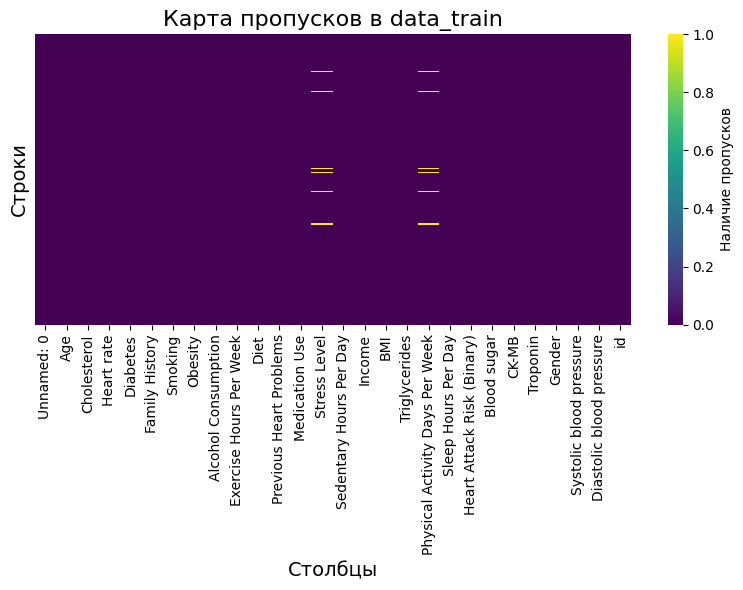

In [26]:
analyze_missing_values(data_train, visualisation=True)

In [27]:
# Находим строки, где есть хотя бы одно пропущенное значение (в любом столбце)
rows_with_na = data_train.isna().any(axis=1)
#Фильтруем, оставляя только строки с пропусками
filtered_data_train = data_train[rows_with_na]
# считаем количество уникальных значений в столбцах
filtered_data_train.nunique()

Unnamed: 0                         243
Age                                 58
Cholesterol                          1
Heart rate                          63
Diabetes                             1
Family History                       1
Smoking                              1
Obesity                              1
Alcohol Consumption                  1
Exercise Hours Per Week              1
Diet                                 1
Previous Heart Problems              1
Medication Use                       1
Stress Level                         0
Sedentary Hours Per Day              1
Income                               1
BMI                                  1
Triglycerides                        1
Physical Activity Days Per Week      0
Sleep Hours Per Day                  1
Heart Attack Risk (Binary)           1
Blood sugar                        120
CK-MB                              210
Troponin                           103
Gender                               2
Systolic blood pressure  

In [28]:
data_train['Gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

**Вывод**
В датасете `data_train` обнаружено 2 187 пропусков (1,01 % от общего объёма). Пропуски присутствуют только в 9 категориальных признаках, и для каждого из них количество пропусков одинаково — 243 (2,8 % от общего числа записей). Остальные 16 столбцов не содержат пропусков.

Отфильтровав двнные со строками содержащими пропуски и подсчитав количество уникальных значений для каждой категории можно прийти к выводу
1. Все 2187 пропусков наблюдаются исключитеьно в 243 строках. что подтверждается тепловой картой и количеством уникальных значений параметра `id`\
   что составляет 2.8% от всех наблюдений
2. Ряд признаков( `cholesterol`, `exercise_hours_per_week`, `diet`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `sleep_hours_per_day`, `heart_attack_risk`)  имеют только одно уникальное значение. Это может означать либо системную ошибку, либо что все пациенты с пропусками имеют такие же общие параметры (что маловероятно)
3. в строках которые содержат пропуски, значение параметра `gender` не типичное ('Male', 'Female') а содержит ьинарное значение 0 или 1. Нет возможности определеить правильный класс


**Итог** Неоднородность в 9 признаках и пропуски еще в 9 признаках показывают критическую неполноту данных, что не позволяет их дальнейшее использование. такие данные необходимо удалить


In [29]:
data_train = data_train.dropna()

In [30]:
data_train.isna().count()

Unnamed: 0                         8442
Age                                8442
Cholesterol                        8442
Heart rate                         8442
Diabetes                           8442
Family History                     8442
Smoking                            8442
Obesity                            8442
Alcohol Consumption                8442
Exercise Hours Per Week            8442
Diet                               8442
Previous Heart Problems            8442
Medication Use                     8442
Stress Level                       8442
Sedentary Hours Per Day            8442
Income                             8442
BMI                                8442
Triglycerides                      8442
Physical Activity Days Per Week    8442
Sleep Hours Per Day                8442
Heart Attack Risk (Binary)         8442
Blood sugar                        8442
CK-MB                              8442
Troponin                           8442
Gender                             8442


In [31]:
data_train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

#### Обработка пропусков тестовой выборки


Общая статистика пропусков для data_test:
Всего пропусков: 62
Процент пропусков от общего объема: 0.24%

Пропуски по столбцам:
                                 Количество пропусков  Процент пропусков
Stress Level                                       31             3.2091
Physical Activity Days Per Week                    31             3.2091
Unnamed: 0                                          0             0.0000
Heart rate                                          0             0.0000
Diabetes                                            0             0.0000
Family History                                      0             0.0000
Smoking                                             0             0.0000
Obesity                                             0             0.0000
Alcohol Consumption                                 0             0.0000
Age                                                 0             0.0000
Cholesterol                                         0             0.0

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
27,27,0.3708,0.4998,0.0348,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.1818,0.0118,0.0002,1.0,0.4194,0.4419,9613
37,37,0.5730,0.4998,0.0431,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.1680,0.0112,0.0010,1.0,0.7226,0.7326,9471
58,58,0.5169,0.4998,0.0458,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.0988,0.0364,0.0022,1.0,0.3871,0.5000,9486
60,60,0.3708,0.4998,0.0568,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.1996,0.0060,0.0064,1.0,0.3871,0.2209,9391
61,61,0.4831,0.4998,0.0284,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.1126,0.0131,0.0007,1.0,0.4194,0.3256,9579
156,156,0.5169,0.4998,0.0458,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.2194,1.0000,0.0006,1.0,0.3355,0.2209,9490
208,208,0.4494,0.4998,0.0367,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.2648,0.0089,0.0021,1.0,0.3806,0.1860,9617
235,235,0.3258,0.4998,0.0293,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.1285,0.0022,0.0006,0.0,0.3871,0.3023,9465
265,265,0.4719,0.4998,0.0568,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.0830,0.0202,0.0005,0.0,0.0968,0.4419,9562
339,339,0.3483,0.4998,0.0541,True,True,True,True,True,0.5021,3,True,True,<NA>,0.4999,0.4949,0.4948,0.5036,<NA>,0.5046,0.2075,0.0061,0.0004,0.0,0.1742,0.1512,9412


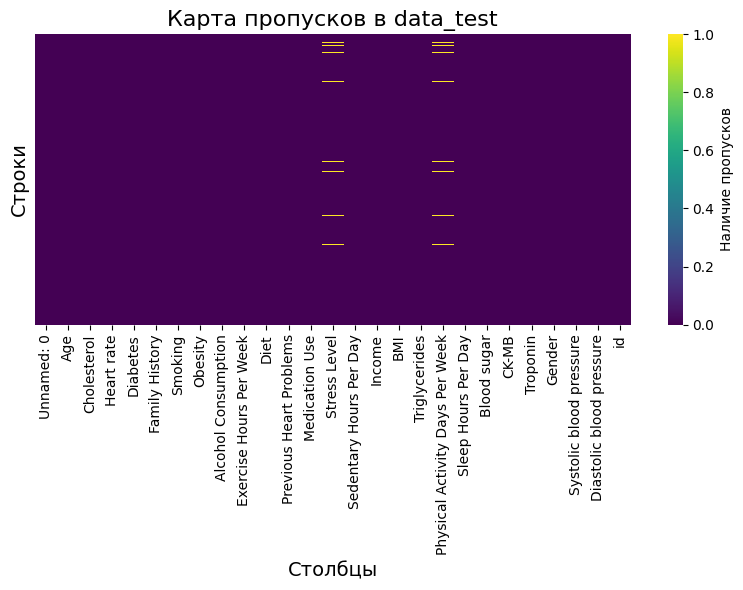

In [32]:
analyze_missing_values(data_test, visualisation=True)

In [33]:
# Находим строки, где есть хотя бы одно пропущенное значение (в любом столбце)
rows_with_na = data_test.isna().any(axis=1)
#Фильтруем, оставляя только строки с пропусками
filtered_data_test = data_test[rows_with_na]
# считаем количество уникальных значений в столбцах
filtered_data_test.nunique()

Unnamed: 0                         31
Age                                19
Cholesterol                         1
Heart rate                         23
Diabetes                            1
Family History                      1
Smoking                             1
Obesity                             1
Alcohol Consumption                 1
Exercise Hours Per Week             1
Diet                                1
Previous Heart Problems             1
Medication Use                      1
Stress Level                        0
Sedentary Hours Per Day             1
Income                              1
BMI                                 1
Triglycerides                       1
Physical Activity Days Per Week     0
Sleep Hours Per Day                 1
Blood sugar                        29
CK-MB                              31
Troponin                           23
Gender                              2
Systolic blood pressure            24
Diastolic blood pressure           21
id          

**Вывод**
В датасете `data_test` обнаружено 279 пропусков (1,2 % от общего объёма). Пропуски присутствуют только в 9 категориальных признаках (таких же что и в тренировочном датасете), и для каждого из них количество пропусков одинаково — 31 (3.2 % от общего числа записей). Остальные 16 столбцов не содержат пропусков.

Отфильтровав двнные со строками содержащими пропуски и подсчитав количество уникальных значений для каждой категории можно прийти к выводу
1. Все 279 пропусков наблюдаются исключитеьно в 31 строке. что подтверждается тепловой картой и количеством уникальных значений параметра `id`\
   что составляет 3,2% от всех наблюдений
2. Ряд признаков( `cholesterol`, `exercise_hours_per_week`, `diet`, `sedentary_hours_per_day`, `income`, `bmi`, `triglycerides`, `sleep_hours_per_day`, `heart_attack_risk`)  имеют только одно уникальное значение. Это может означать либо системную ошибку, либо что все пациенты с пропусками имеют такие же общие параметры (что маловероятно)


**Итог** Неоднородность в 9 признаках и пропуски еще в 9 признаках показывают критическую неполноту данных, что не позволяет их дальнейшее использование. такие данные необходимо удалить


In [34]:
data_test = data_test.dropna()

In [35]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       935 non-null    int64  
 1   Age                              935 non-null    float64
 2   Cholesterol                      935 non-null    float64
 3   Heart rate                       935 non-null    float64
 4   Diabetes                         935 non-null    bool   
 5   Family History                   935 non-null    bool   
 6   Smoking                          935 non-null    bool   
 7   Obesity                          935 non-null    bool   
 8   Alcohol Consumption              935 non-null    bool   
 9   Exercise Hours Per Week          935 non-null    float64
 10  Diet                             935 non-null    int64  
 11  Previous Heart Problems          935 non-null    bool   
 12  Medication Use             

In [36]:
data_test['Gender'].unique()

array(['Male', 'Female'], dtype=object)

### Проверка на дубликаты

In [37]:
def check_remove_duplicates(df, column_name=None, remove_duplicates=False, keep='first', n_rows=10):
    """
    Функция для проверки и удаления дубликатов во всем датасете или в конкретном столбце
    
    Параметры:
    df - DataFrame
    column_name - имя столбца (None для проверки всего датафрейма)
    remove_duplicates - флаг для удаления дубликатов
    keep - какие дубликаты сохранять ('first', 'last', False)
    n_rows - количество строк для вывода в примере
    
    Возвращает: обработанный DataFrame
    """
    
    # Определяем область поиска дубликатов
    subset = [column_name] if column_name else None
    text = f'в столбце "{column_name}"' if column_name else 'во всем датафрейме'
    
    # Создаем копию датафрейма для работы
    copy_df = df.copy()
    
    # Вычисление статистики
    dup_mask = copy_df.duplicated(subset=subset, keep=False)
    total = len(copy_df)
    dup_count = dup_mask.sum()
    dup_pct = (dup_count / total) * 100 if total > 0 else 0
    def separator():
        print("=" * 60)

    # Вывод статистики
    print(f'Анализ дубликатов {text}:')
    separator()
    print(f"Всего записей: {total}")
    print(f"Дубликатов: {dup_count}")
    print(f"Процент: {dup_pct:.2f}%")
    
    # Вывод примеров дубликатов
    if dup_count > 0:
        print(f'\nПримеры дублирующихся строк (первые {n_rows}):')
        sort_columns = [column_name] if column_name else copy_df.columns.tolist()
        display(copy_df[dup_mask].sort_values(by=sort_columns).head(n_rows))
    
    # Удаление дубликатов
    if remove_duplicates:
        start_len = len(copy_df)
        copy_df = copy_df.drop_duplicates(subset=subset, keep=keep)
        removed = start_len - len(copy_df)
        
        separator()
        print('Результат удаления дубликатов:')
        separator()
        print(f'Удалено записей: {removed}')
        print(f"Осталось записей: {len(copy_df)}")
        
        return copy_df
    separator()
    

#### Проверка на дубликаты тренировочных данных

In [38]:
check_remove_duplicates(data_train, column_name='id')

Анализ дубликатов в столбце "id":
Всего записей: 8442
Дубликатов: 0
Процент: 0.00%


#### Проверка на дубликаты тестовых данных

In [39]:
check_remove_duplicates(data_test, column_name='id')

Анализ дубликатов в столбце "id":
Всего записей: 935
Дубликатов: 0
Процент: 0.00%


**Выводы**

Дубликаты в тренировочных и тестовых данных не обнаружены

## EDA

#### Общая информация и описательная статистика

In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8442 non-null   int64  
 1   Age                              8442 non-null   float64
 2   Cholesterol                      8442 non-null   float64
 3   Heart rate                       8442 non-null   float64
 4   Diabetes                         8442 non-null   bool   
 5   Family History                   8442 non-null   bool   
 6   Smoking                          8442 non-null   bool   
 7   Obesity                          8442 non-null   bool   
 8   Alcohol Consumption              8442 non-null   bool   
 9   Exercise Hours Per Week          8442 non-null   float64
 10  Diet                             8442 non-null   int64  
 11  Previous Heart Problems          8442 non-null   bool   
 12  Medication Use           

In [41]:
data_train.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Exercise Hours Per Week,Diet,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000,8442.0,8442.0000,8442.0000,8442.0000,8442.0000,8442.0,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000,8442.0000
mean,4341.2797,0.4490,0.5011,0.0502,0.5034,1.0015,5.4934,0.4991,0.4961,0.4968,0.5055,3.5083,0.5037,0.2280,0.0477,0.0369,0.4520,0.5017,4696.3921
std,2509.2233,0.2328,0.2888,0.0184,0.2889,0.8130,2.8679,0.2894,0.2888,0.2866,0.2904,2.2818,0.3327,0.0746,0.0704,0.0593,0.1702,0.1703,2704.7733
min,0.0000,0.0449,0.0000,0.0183,0.0000,0.0000,1.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.1613,0.2093,1.0000
25%,2175.2500,0.2472,0.2607,0.0348,0.2534,0.0000,3.0,0.2477,0.2446,0.2479,0.2571,2.0,0.1667,0.2270,0.0482,0.0365,0.3032,0.3488,2359.2500
50%,4335.5000,0.4607,0.4964,0.0504,0.5082,1.0000,5.0,0.4927,0.4961,0.4908,0.5078,3.0,0.5000,0.2270,0.0482,0.0365,0.4516,0.5000,4694.5000
75%,6518.7500,0.6404,0.7500,0.0660,0.7549,2.0000,8.0,0.7510,0.7476,0.7444,0.7584,6.0,0.8333,0.2270,0.0482,0.0365,0.6000,0.6512,7030.7500
max,8684.0000,0.8539,1.0000,0.0825,1.0000,2.0000,10.0,1.0000,1.0000,1.0000,1.0000,7.0,1.0000,1.0000,1.0000,1.0000,0.7419,0.7907,9376.0000


**Выводы**

Датасет подготовлен, отсутствуют пропуски, числовые признаки масштабированы\
Признаки включают медицинские показатели, характеристики образа жизни и бинарные факторы риска\

### Анализ числовых признаков

In [42]:
def analyze_feature(df, feature, bins=50, title=None, figsize=(12,5), delta_y=1, rename_columns = None, only_chart = False):
    """
    Проводит комплексный анализ признака (столбца) в DataFrame, включая визуализацию
    распределения и статистический анализ выбросов.

    Функция создает два графика:
    1. Гистограмму распределения с кривой KDE и линиями среднего/медианы
    2. Boxplot ("ящик с усами") для визуализации выбросов

    Также вычисляет и возвращает границы для определения выбросов по правилу 1.5*IQR.

    Параметры:
    ----------
    df : pandas.DataFrame
        DataFrame, содержащий анализируемый признак.
    
    feature : str
        Название столбца в DataFrame для анализа.
    
    bins : int, optional, default=50
        Количество бинов для гистограммы.
    
    title : str or None, optional, default=None
        Заголовок для графиков. Если None, используется название признака.
    
    figsize : tuple, optional, default=(12, 5)
        Размер фигуры с графиками в дюймах (ширина, высота).
    
    delta_y : int or float, optional, default=1
        Коэффициент увеличения верхней границы оси Y для гистограммы.
        Используется для предотвращения наложения легенды на график.
    
    rename_columns : dict or None, optional, default=None
        Словарь для переименования столбцов при выводе текста.
        Ключ - исходное название, значение - новое отображаемое название.
    
    only_chart : bool, optional, default=False
        Если True, выводится только график без текстовой статистики.
        Если False, выводится полный анализ со статистикой.

    Возвращает:
    -----------
    tuple : (lower_bound, upper_bound)
        lower_bound : float
            Нижняя граница для определения выбросов по правилу 1.5*IQR.
        upper_bound : float
            Верхняя граница для определения выбросов по правилу 1.5*IQR.

    Примеры:
    --------
    >>> lower, upper = analyze_feature(df, 'price', bins=30, title='Цена товара')
    >>> lower, upper = analyze_feature(df, 'age', rename_columns={'age': 'Возраст'})
    >>> analyze_feature(df, 'salary', only_chart=True)  # Только график без текста
    """
    
    if rename_columns:
       text = f"параметра: {rename_columns[feature]}"
    elif title:
       text = f"параметра: {title}"
    else:
       text = f"параметра: {feature}"
    
    if not only_chart:
        separator()
        print("Анализ " + text)
       
        # описательная статистика
        print(f"\nОписательная статистика {text}:")
        stats = df[feature].describe().apply(lambda x: format(x, '0.2f'))
        #pint(stats.map(lambda x: locale.format_string("%.2f", x, grouping=True).replace(',', ' ')))
        print(stats)

    label = feature if title else title
    # Создаем финуру с несколькими  графиками
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)
    plt.subplots_adjust(wspace=0.3)  # Увеличено пространство между графиками
    # задаем цета для графиков
    hist_color = '#3498db'  # Синий
    kde_color = '#e74c3c'   # Красный
    mean_color = '#16a085'  # Зеленый
    median_color = '#f39c12' # Оранжевый

    # строим гистограмму распределения
    sns.histplot(data=df[feature],
                 bins=bins,
                 edgecolor=hist_color,
                 linewidth=1,
                 alpha=0.6,
                 label='Распределение',
                 kde=True,
                 ax=ax1).lines[0].set_color(kde_color)
    
   # добавим линии среднего и медианы
    mean = df[feature].mean()
    median = df[feature].median()
    ax1.axvline(mean, color=mean_color, linestyle='--', 
                linewidth=2.5, label=f'Среднее: {mean:.2f}')
    ax1.axvline(median, color=median_color, linestyle=':', 
                linewidth=2.5, label=f'Медиана: {median:.2f}')
    
    # Настройки оформления
    ax1.set_title(f"Гистограмма распределения\n{text}", fontsize=14, pad=10)
    ax1.set_xlabel(title, fontsize=12)
    ax1.set_ylabel('Плотность', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10, framealpha=1, shadow=True)
   
    y_max = ax1.get_ylim()[1]  # Текущий максимум оси Y
    ax1.set_ylim(top=y_max * delta_y)  # Добавляем  отступа сверху чтобы легенда не заползала на график (при необходимости)


    # график "ящик с усами" (боксплот)
    box_color = '#3498db'
    sns.boxplot(x=df[feature], 
                color=box_color, 
                width=0.3, 
                linewidth=2, 
                # настроим отображение выбросов
                flierprops=dict(
                    marker='D', # ромб
                    markersize=5, 
                    markerfacecolor='#e74c3c'), 
                ax=ax2)
    ax2.set_title(f'"Ящик с усами" для\n{text}', fontsize=14, pad=10)
    ax2.set_xlabel('')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    
    plt.tight_layout(pad=3, h_pad=2, w_pad=3)
    plt.show()
    
# анализ выбросов  (правило 1.5 * IQR)
# Любая точка данных, которая на 1,5 IQR ниже первого квартиля или выше третьего, является выбросом
    
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
        
    if not only_chart:
        print(f"\nМежквартильный размах: {iqr:.3f}")
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    if not only_chart:
        print(f"\nКоличество выбросов: {len(outliers)}")
        if len(outliers)>0:
            print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print("\nПримеры выбросов:")
            print(outliers[feature].head(10))
            separator()
        else:
            separator()
    
    return lower_bound, upper_bound

#### Анализ параметра `Age` - 'Возраст'

Анализ параметра: Возраст

Описательная статистика параметра: Возраст:
count    8442.00
mean        0.45
std         0.23
min         0.04
25%         0.25
50%         0.46
75%         0.64
max         0.85
Name: Age, dtype: object


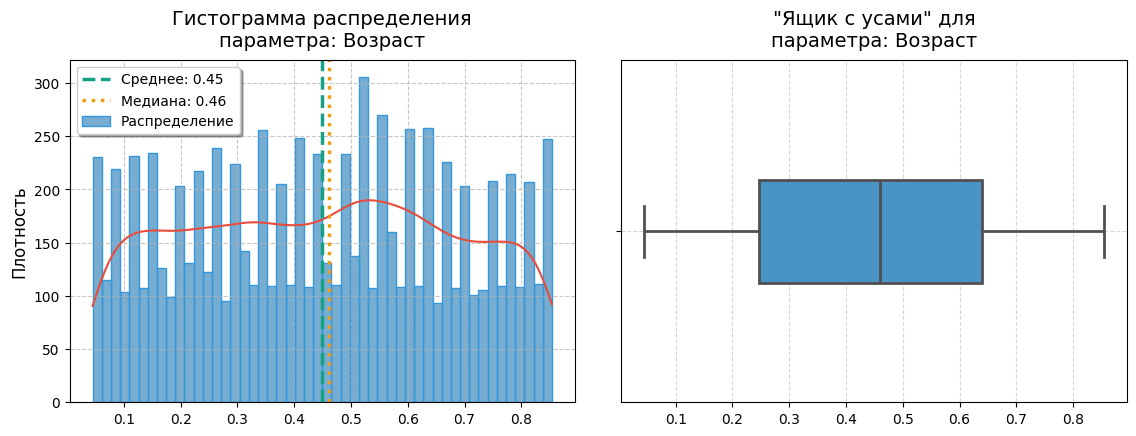


Межквартильный размах: 0.393

Количество выбросов: 0


(np.float64(-0.3426966292134833), np.float64(1.2303370786516856))

In [43]:
analyze_feature(data_train, feature='Age', rename_columns = {'Age':'Возраст'})

##### Выводы

Распределение мультимодальное, множество пиков, с небольщой правосторонней ассиметрией (среднее меньше медианы), но при этом кривая плтности почти ровная.
Пики согут соответствовать разным возрастным группам

Выбросы отсутствуют

#### Анализ параметра `Cholesterol` - "Количество холестерина в крови"

Анализ параметра: Кол-во холестерина в крови

Описательная статистика параметра: Кол-во холестерина в крови:
count    8442.00
mean        0.50
std         0.29
min         0.00
25%         0.26
50%         0.50
75%         0.75
max         1.00
Name: Cholesterol, dtype: object


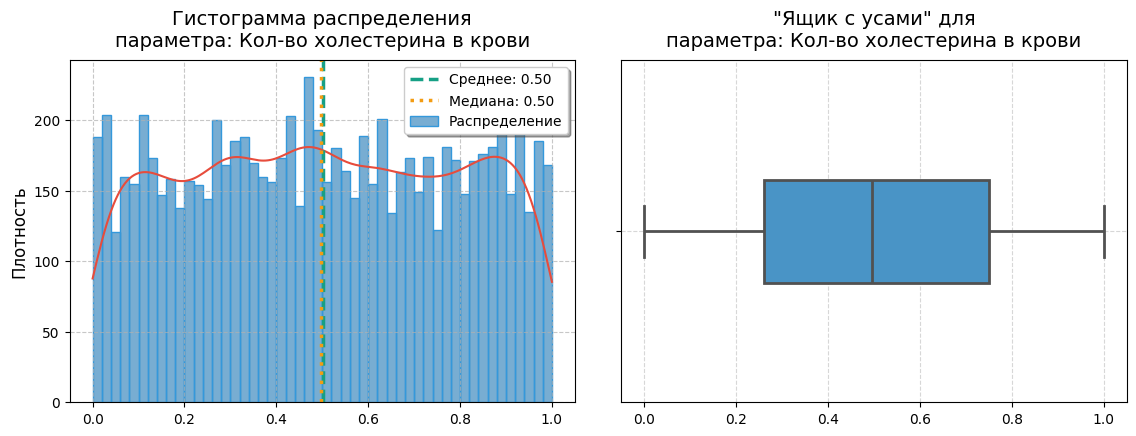


Межквартильный размах: 0.489

Количество выбросов: 0


(np.float64(-0.4732142857142858), np.float64(1.4839285714285715))

In [44]:
analyze_feature(data_train, 
                feature='Cholesterol',  
                rename_columns = {'Cholesterol':'Кол-во холестерина в крови'})

##### Выводы

Распределение мультимодальное но близкое к равномерному , множество пиков, но при этом симетричное (среднее и медиана совпадают).

Равномерность распределения может указывать на то, что в выборке представлены пациенты с разным уровнем холестерина без явного смещения к крайним значениям

разброс значений можно считать значительным (стандартное отклонение 0,29)

Выбросы отсутствуют

#### Анализ параметра `Heart rate` - "ЧСС, Частота сердечных сокращений"

Анализ параметра: ЧСС

Описательная статистика параметра: ЧСС:
count    8442.00
mean        0.05
std         0.02
min         0.02
25%         0.03
50%         0.05
75%         0.07
max         0.08
Name: Heart rate, dtype: object


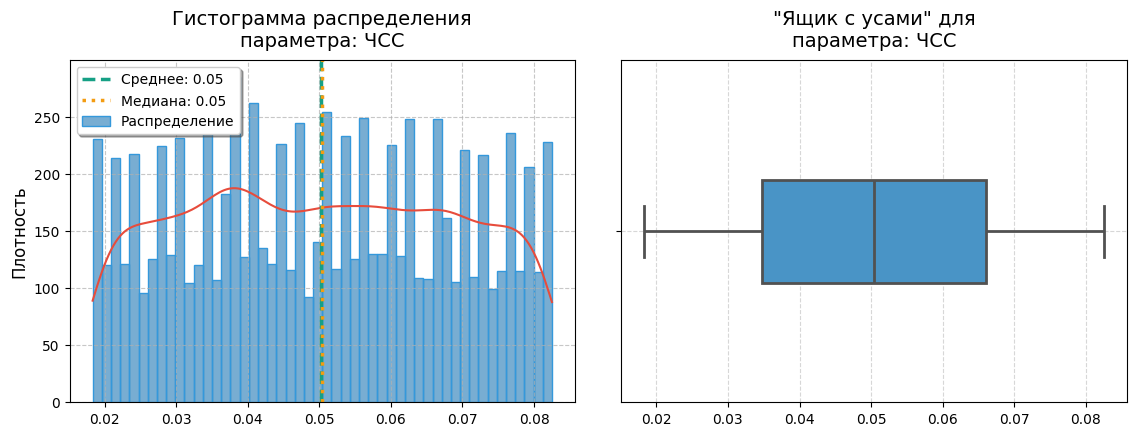


Межквартильный размах: 0.031

Количество выбросов: 0


(np.float64(-0.011915673693858896), np.float64(0.11274060494958749))

In [45]:
analyze_feature(data_train, 
                feature='Heart rate',  
                rename_columns = {'Heart rate':'ЧСС'})

##### Выводы

Распределение мультимодальное, но форма близка к нормальному типу, множество пиков, но при этом симетричное (среднее и медиана равны)
Разброс значений значительный - стандартное отклонение 0.02
Пики могут зависеть от других параметров, например возраста пациентов


Можно заметить что если параметр `Heart rate` и был нормализован, то его значение уменьшено в 10 раз
Для уравниявания весов признаков рекомендуется корректно масштабировать значение показателя Heart rate увеличив его в 10 раз
Будет сделоно при подготовке пайплайна

Выбросы отсутствуют

#### Анализ параметра `Exercise Hours Per Week` - "Часы физических упражнений в неделю"

Анализ параметра: Часы физических упражнений

Описательная статистика параметра: Часы физических упражнений:
count    8442.00
mean        0.50
std         0.29
min         0.00
25%         0.25
50%         0.51
75%         0.75
max         1.00
Name: Exercise Hours Per Week, dtype: object


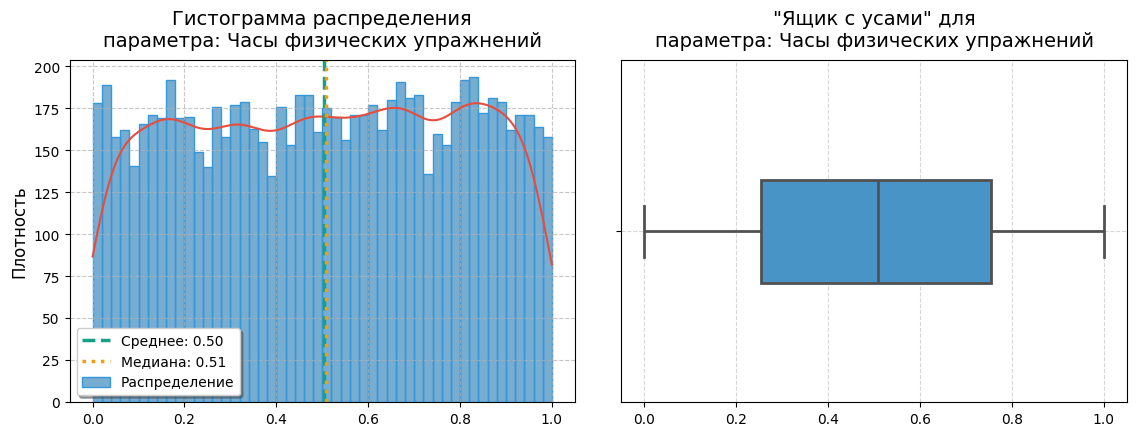


Межквартильный размах: 0.502

Количество выбросов: 0


(np.float64(-0.49895356454586776), np.float64(1.5072143976000565))

In [46]:
analyze_feature(data_train, 
                feature='Exercise Hours Per Week', 
                rename_columns = {'Exercise Hours Per Week':'Часы физических упражнений'})

##### Выводы

Форма распределения близка к нормальному, при этом симетричное (среднее и медиана почти равны)\
Разброс значений умеренный - стандартное отклонение 0.29 но большинство значений расположено вокруг среднего

Выбросы отсутствуют

#### Анализ параметра `Sedentary Hours Per Day` - "Часы сидячего образа жизни в день"

Анализ параметра: Часы сидячего образа жизни в день

Описательная статистика параметра: Часы сидячего образа жизни в день:
count    8442.00
mean        0.50
std         0.29
min         0.00
25%         0.25
50%         0.49
75%         0.75
max         1.00
Name: Sedentary Hours Per Day, dtype: object


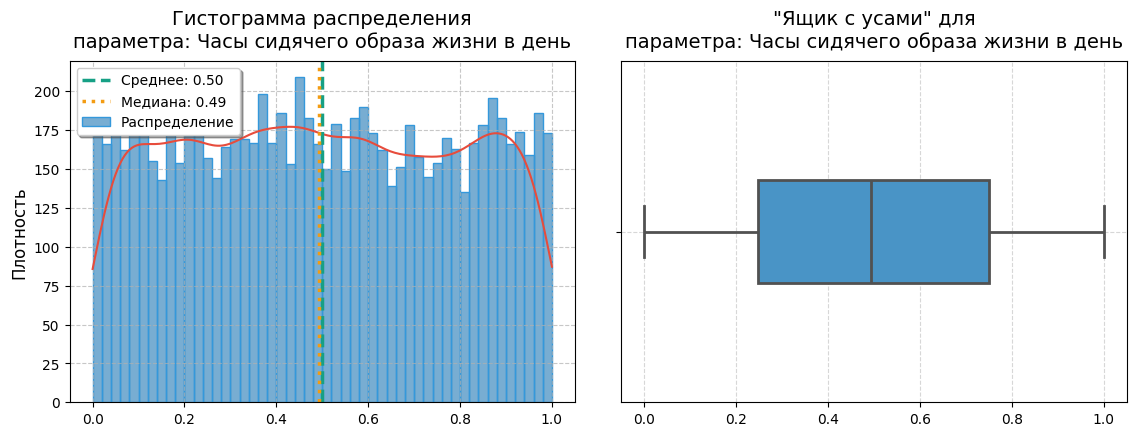


Межквартильный размах: 0.503

Количество выбросов: 0


(np.float64(-0.5074448999235285), np.float64(1.5061424398679932))

In [47]:
analyze_feature(data_train, 
                feature='Sedentary Hours Per Day', 
                rename_columns = {'Sedentary Hours Per Day':'Часы сидячего образа жизни в день'})

##### Выводы

Форма распределения близка к нормальному, при этом симетричное (среднее и медиана почти равны)\
Разброс значений можно считать значительным - стандартное отклонение 0.29 но большинство значений расположено вокруг среднего

Выбросы отсутствуют

#### Анализ параметра `Income` - "Доход"

Анализ параметра: Доход

Описательная статистика параметра: Доход:
count    8442.00
mean        0.50
std         0.29
min         0.00
25%         0.24
50%         0.50
75%         0.75
max         1.00
Name: Income, dtype: object


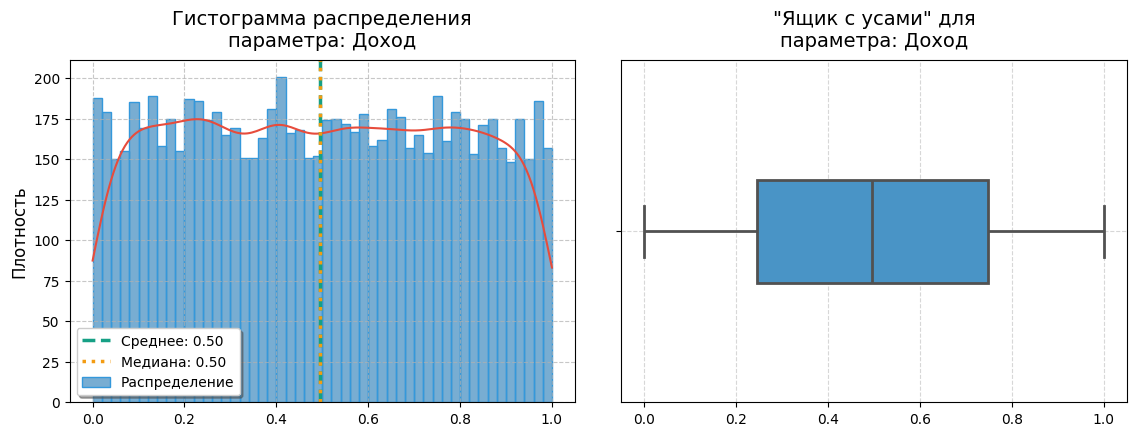


Межквартильный размах: 0.503

Количество выбросов: 0


(np.float64(-0.5099270432881257), np.float64(1.5021204607491463))

In [48]:
analyze_feature(data_train, feature='Income', rename_columns = {'Income':'Доход'})

##### Выводы

Форма распределения близка к нормальному, при этом симетричное (среднее и медиана равны)\
Разброс значений можно считать значительным - стандартное отклонение 0.29 но большинство значений расположено вокруг среднего

Выбросы отсутствуют

#### Анализ параметра `BMI` - "Индекс массы тела"

Анализ параметра: Индекс массы тела

Описательная статистика параметра: Индекс массы тела:
count    8442.00
mean        0.50
std         0.29
min         0.00
25%         0.25
50%         0.49
75%         0.74
max         1.00
Name: BMI, dtype: object


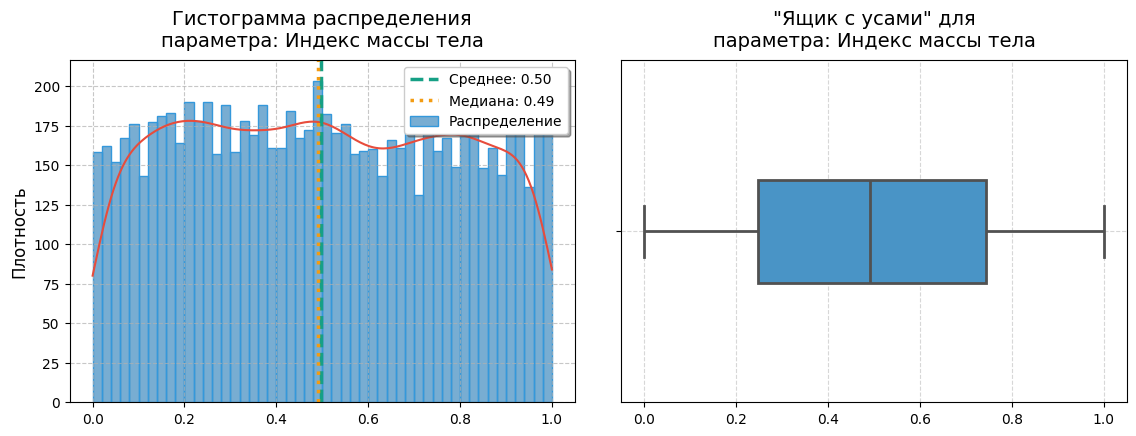


Межквартильный размах: 0.496

Количество выбросов: 0


(np.float64(-0.49676186352586466), np.float64(1.4890954594921912))

In [49]:
analyze_feature(data_train, feature='BMI', rename_columns = {'BMI':'Индекс массы тела'})

##### Выводы

Форма распределения близка к нормальному, при этом симетричное (среднее и медиана почти равны)\
Разброс значений умеренный - стандартное отклонение 0.29 но большинство значений расположено вокруг среднего

Выбросы отсутствуют

#### Анализ параметра `Triglycerides` - "содержание Триглицеридов"

Анализ параметра: содержание Триглицеридов

Описательная статистика параметра: содержание Триглицеридов:
count    8442.00
mean        0.51
std         0.29
min         0.00
25%         0.26
50%         0.51
75%         0.76
max         1.00
Name: Triglycerides, dtype: object


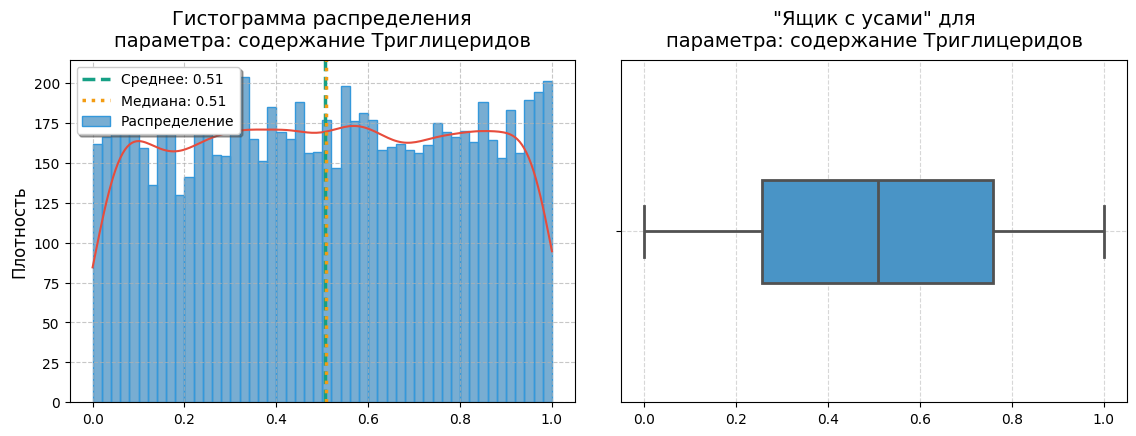


Межквартильный размах: 0.501

Количество выбросов: 0


(np.float64(-0.4948051948051949), np.float64(1.5103896103896104))

In [50]:
analyze_feature(data_train, feature='Triglycerides', 
                rename_columns = {'Triglycerides':'содержание Триглицеридов'})

##### Выводы

Форма распределения близка к нормальному, при этом симетричное (среднее и медиана равны)\
Разброс значений можно считать значительным - стандартное отклонение 0.29 но большинство значений расположено вокруг среднего

Выбросы отсутствуют

#### Анализ параметра `Sleep Hours Per Day` - "Количество часов сна в день"

Анализ параметра: Количество часов сна в день

Описательная статистика параметра: Количество часов сна в день:
count    8442.00
mean        0.50
std         0.33
min         0.00
25%         0.17
50%         0.50
75%         0.83
max         1.00
Name: Sleep Hours Per Day, dtype: object


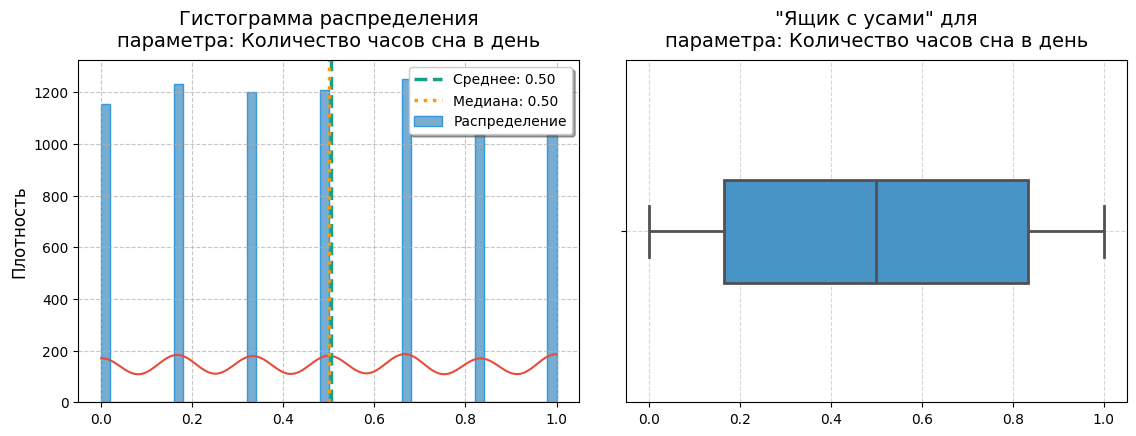


Межквартильный размах: 0.667

Количество выбросов: 0


(np.float64(-0.8333333333333334), np.float64(1.8333333333333335))

In [51]:
analyze_feature(data_train, feature='Sleep Hours Per Day', 
                rename_columns = {'Sleep Hours Per Day':'Количество часов сна в день'})

In [52]:
data_train['Sleep Hours Per Day'].nunique()

7

In [53]:
data_train['Sleep Hours Per Day'].value_counts().sort_index()

Sleep Hours Per Day
0.0000    1153
0.1667    1231
0.3333    1200
0.5000    1208
0.6667    1252
0.8333    1137
1.0000    1261
Name: count, dtype: int64

##### Выводы

Хотя данные и были нормализованы, параметр `Sleep Hours Per Day` относиться к категориальному признаку, так как четко видны 7 отдельных пиков (категорий)

Необходимо привести данные к категориальному виду

#### Анализ параметра `Blood sugar` - "Содержание сахара в крови"

Анализ параметра: Содержание сахара в крови

Описательная статистика параметра: Содержание сахара в крови:
count    8442.00
mean        0.23
std         0.07
min         0.00
25%         0.23
50%         0.23
75%         0.23
max         1.00
Name: Blood sugar, dtype: object


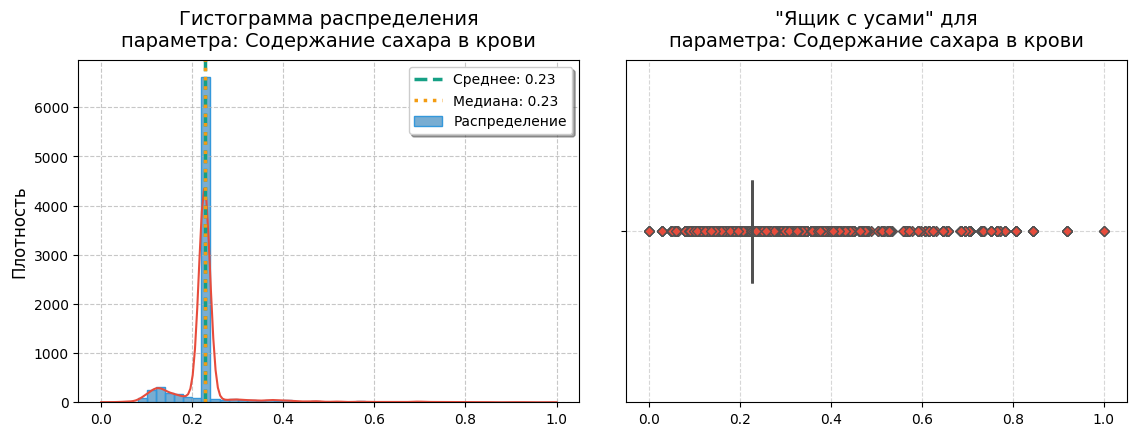


Межквартильный размах: 0.000

Количество выбросов: 1891
Границы выбросов: [0.23, 0.23]

Примеры выбросов:
1     0.1502
6     0.2312
8     0.1265
14    0.3103
26    0.3142
35    0.1423
40    0.1245
44    0.3419
48    0.1739
50    0.1621
Name: Blood sugar, dtype: float64


(np.float64(0.2270175751137986), np.float64(0.2270175751137986))

In [54]:
analyze_feature(data_train, feature='Blood sugar', 
                rename_columns = {'Blood sugar':'Содержание сахара в крови'})

##### Предварительные выводы

Распределение параметра `blood_sugar` ассиметричное и сильно скошено вправо, с длинным хвостом.
Основная часть значений сосредоточена в узком диапазоне от 0.22 до 0.24, что указывает на стабильность. стандартное отклонение 0.07

Экстремальные выбросы наблюдаются в области выше 0.6 и менее 0.1

Общее количество выбросов: 1891

для устранения выбросов можно применить логарифмирование, так как отрицательные значения отсутствуют

In [55]:
# Добавим небольшую константу, так как в данных присутствуют нулевые значения
data_train['blood_sugar_log'] = np.log(data_train['Blood sugar'] + 0.001)

Анализ параметра: Содержание сахара в крови (логарифмированно)

Описательная статистика параметра: Содержание сахара в крови (логарифмированно):
count    8442.00
mean       -1.51
std         0.29
min        -6.91
25%        -1.48
50%        -1.48
75%        -1.48
max         0.00
Name: blood_sugar_log, dtype: object


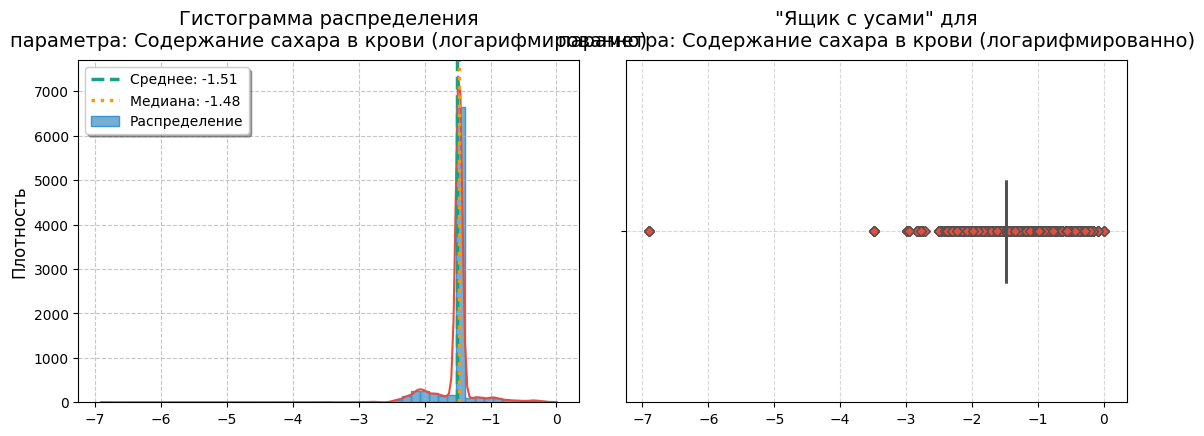


Межквартильный размах: 0.000

Количество выбросов: 1891
Границы выбросов: [-1.48, -1.48]

Примеры выбросов:
1    -1.8892
6    -1.4600
8    -2.0598
14   -1.1671
26   -1.1545
35   -1.9429
40   -2.0754
44   -1.0703
48   -1.7435
50   -1.8137
Name: blood_sugar_log, dtype: float64


(np.float64(-1.4783325691660523), np.float64(-1.4783325691660523))

In [56]:
analyze_feature(data_train, feature='blood_sugar_log', 
                rename_columns = {'blood_sugar_log':'Содержание сахара в крови (логарифмированно)'})

##### Выводы 
Логарифмирование не помогло. удаление выбросов приведет к значительной потере данных, а замена выбросов на граничные значения квантилей сделает данный параметр неинформативным, так как все значения будут сосредоточены в крайне узком диапазоне.

Возможно разбить данные на категории, Низкий норма высокий, но для разных возрастных групп существуют разные таблицы нормального уровня содержания сахара. 

В рамках данного исследвания оставим данный параметр неизменным

In [57]:
data_train = data_train.drop(['blood_sugar_log'], axis=1)

#### Анализ параметра `Systolic blood pressure` - "Cистолическое давление"

Анализ параметра: Cистолическое давление

Описательная статистика параметра: Cистолическое давление:
count    8442.00
mean        0.45
std         0.17
min         0.16
25%         0.30
50%         0.45
75%         0.60
max         0.74
Name: Systolic blood pressure, dtype: object


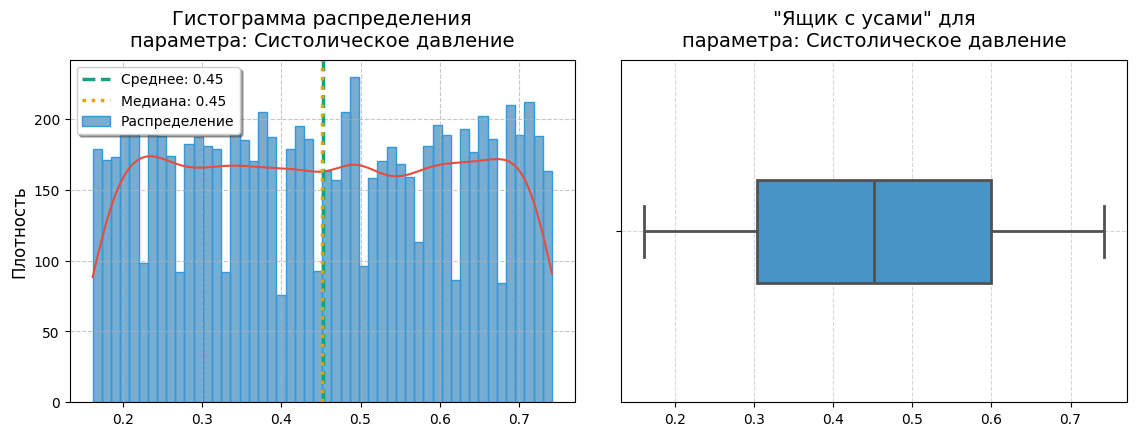


Межквартильный размах: 0.297

Количество выбросов: 0


(np.float64(-0.14193548387096783), np.float64(1.0451612903225804))

In [58]:
analyze_feature(data_train, feature='Systolic blood pressure', 
                rename_columns = {'Systolic blood pressure':'Cистолическое давление'})

##### Выводы 

Распределение выглядит относительно равномерным и симетричным (среднее и медиана совпадают), нр при этом видно 10 четких пиков, что может указывать на наличие нескольких подгрупп в данных (например, различные группы пациентов).
Плотность остается высокой на всем диапазоне от 0.2 до 0.7
разброс данных (при стандартном отклонении 0.17) можно считать значительным

Выбросы отсутствуют. 

Для улучшения корреляции с целевой переменной можно рассмотреть вариант категоризации признака


#### Анализ параметра `Diastolic blood pressure` - "Диастолическое давление"

Анализ параметра: Диастолическое давление

Описательная статистика параметра: Диастолическое давление:
count    8442.00
mean        0.50
std         0.17
min         0.21
25%         0.35
50%         0.50
75%         0.65
max         0.79
Name: Diastolic blood pressure, dtype: object


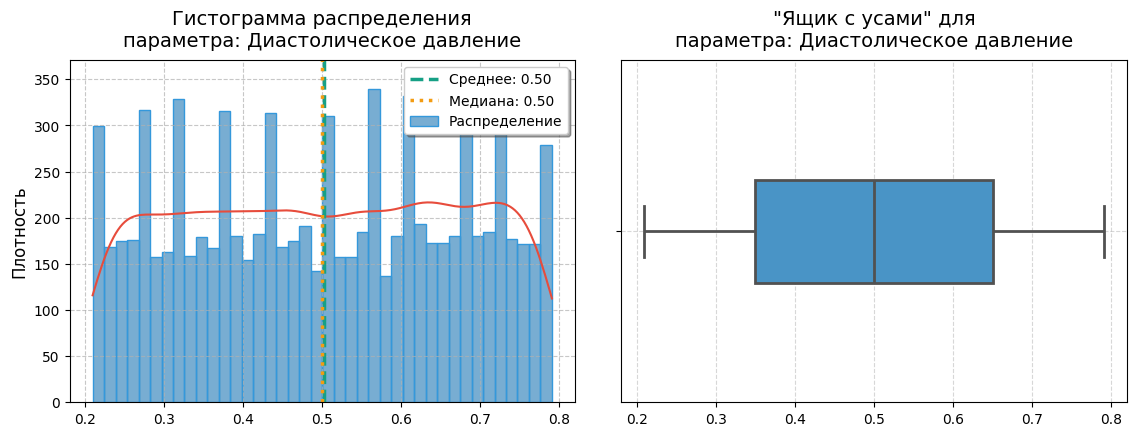


Межквартильный размах: 0.302

Количество выбросов: 0


(np.float64(-0.10465116279069803), np.float64(1.1046511627906979))

In [59]:
analyze_feature(data_train, feature='Diastolic blood pressure', bins=40,    
                rename_columns = {'Diastolic blood pressure':'Диастолическое давление'})

##### Выводы 

Распределение выглядит относительно равномерным/мультимодальным и симетричным (среднее и медиана совпадают), нр при этом видно 11 четких пиков, что может указывать на наличие нескольких подгрупп в данных (например, различные группы пациентов).
Плотность остается высокой на всем диапазоне от 0.25 до 0.75
разброс данных (при стандартном отклонении 0.17) можно считать значительным

Выбросы отсутствуют


Параметры систолическго и диастолического давление имеют почти идентичные характеристики распределения по всем параметрам, кроме их центра.Такое сходство ожидаемо так как эти параметры очень тесно связаны физиологически. Это может подтвердить аналих корреляции. 

#### Важное замечание
 
Распределение почти всех числовых характеристик имеет раномерную/мультимодальную форму что не характерно для реальных данных. можно предположить что данныесинтетические

### Анализ категориальных признаков

In [60]:
def create_charts(data_to_plot, df_name, ax=None, color_map='tab20', title=None, 
                                  figsize=(12, 8), start_angle=90, max_categories=4):
    """
    Создает круговые диаграммы с вынесенными наружу объединенными подписями
    с возможностью поворота и автоматическим переключением на barplot
    
    Parameters:
    -----------
    data_to_plot : dict или list of dicts
        - Для одной диаграммы: dict с ключами 'series', 'title', 'color_map' (опционально)
        - Для нескольких диаграмм: list of dicts
    df : DataFrame
        Исходный DataFrame
    ax : matplotlib.axes.Axes, optional
        Ось для построения одной диаграммы
    color_map : str, optional
        Цветовая карта (по умолчанию 'tab20')
    title : str, optional
        Заголовок для одиночной диаграммы
    figsize : tuple, optional
        Размер фигуры для сетки диаграмм
    start_angle : float, optional
        Угол начала первой секции (по умолчанию 90 - сверху)
    max_categories : int, optional
        Максимальное количество категорий для круговой диаграммы (по умолчанию 4)
        Если категорий больше - строится barplot
    """
    
    def create_pie_chart(ax, values, labels, title, color_map='tab20', start_angle=90):
        """Создает круговую диаграмму с выносками"""
        try:
            cmap = plt.get_cmap(color_map)
        except ValueError:
            cmap = plt.get_cmap('tab20')
        colors = [cmap(i / len(values)) for i in range(len(values))]

        total = sum(values)
        
        # Создаем диаграмму без подписей с заданным углом
        wedges, texts = ax.pie(
            values,
            labels=None,
            startangle=start_angle,
            colors=colors,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
        )
        
        # Добавляем кастомные аннотации с объединенной информацией
        for i, wedge in enumerate(wedges):
            # Вычисляем угол и позицию с учетом start_angle
            theta1 = wedge.theta1
            theta2 = wedge.theta2
            center_angle = (theta1 + theta2) / 2
            angle_rad = np.deg2rad(center_angle)
            
            # Вычисляем процент
            pct = 100. * values[i] / total
            absolute = values[i]
            
            # Создаем объединенную подпись
            label_text = f'{labels[i]}\n{pct:.1f}% ({absolute})'
            
            # Определяем позицию для текста (выносим наружу)
            x = 1.3 * np.cos(angle_rad)
            y = 1.3 * np.sin(angle_rad)
            
            # Определяем выравнивание текста в зависимости от положения
            ha = 'center'
            if abs(x) > 0.5:  # Если сектор сбоку
                ha = 'left' if x > 0 else 'right'
            
            # Добавляем аннотацию
            ax.annotate(
                label_text,
                xy=(np.cos(angle_rad), np.sin(angle_rad)),
                xytext=(x, y),
                ha=ha,
                va='center',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
            )
        
        ax.set_title(title, pad=20, fontsize=12)
        ax.axis('equal')
        
        return wedges
    
    def create_barplot(ax, values, labels, title, color_map='tab20'):
        """Создает горизонтальный barplot для большого количества категорий"""
        try:
            cmap = plt.get_cmap(color_map)
        except ValueError:
            cmap = plt.get_cmap('tab20')
        
        # Сортируем данные по убыванию значений
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = values[sorted_indices]
        sorted_labels = labels[sorted_indices]
        
        # Создаем цвета
        colors = [cmap(i / len(values)) for i in range(len(values))]
        sorted_colors = [colors[i] for i in sorted_indices]
        
        total = sum(values)
        
        # Создаем горизонтальный barplot
        y_pos = range(len(sorted_values))
        bars = ax.barh(y_pos, sorted_values, color=sorted_colors, alpha=0.7, height=0.6)
        
        # Добавляем подписи на барпы
        for i, (bar, value, label) in enumerate(zip(bars, sorted_values, sorted_labels)):
            width = bar.get_width()
            pct = 100. * value / total
            
            # Подпись справа от бара (процент)
            ax.text(width + max(sorted_values)*0.01, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', ha='left', va='center', fontsize=8)
            
            # Подпись слева от бара (название категории)
            ax.text(max(sorted_values)*0.01, bar.get_y() + bar.get_height()/2,
                label, ha='left', va='center', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
            
            # Значение внутри бара (если позволяет ширина)
            if width > max(sorted_values) * 0.3:
                ax.text(width/2, bar.get_y() + bar.get_height()/2,
                    f'{value}', ha='center', va='center', fontsize=9,
                    color='white', fontweight='bold')
        
        # Настройки внешнего вида
        ax.set_title(f'{title}', pad=20, fontsize=12)
        ax.set_xlim(0, max(sorted_values) * 1.2)
        ax.set_ylim(-0.5, len(sorted_values)-0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_yticks([])  # Убираем метки на оси Y
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        return bars
    
    def create_chart(ax, values, labels, title, color_map='tab20', start_angle=90, max_categories=4):
        """Умная функция, выбирающая тип графика в зависимости от количества категорий"""
        if len(values) <= max_categories:
            return create_pie_chart(ax, values, labels, title, color_map, start_angle)
        else:
            return create_barplot(ax, values, labels, title, color_map)
    
    # Обработка режима одиночной диаграммы
    if ax is not None:
        if isinstance(data_to_plot, dict):
            create_chart(ax, 
                        data_to_plot['series'].values, 
                        data_to_plot['series'].index, 
                        title or data_to_plot.get('title', ''),
                        data_to_plot.get('color_map', color_map),
                        start_angle,
                        max_categories)
        return ax
    
    # Режим нескольких диаграмм (сетка)
    else:
        n_charts = len(data_to_plot)
        
        # Рассчитываем сетку графиков: всегда 2 колонки, строки вычисляем
        n_cols = 2
        n_rows = n_charts // n_cols + (1 if n_charts % n_cols != 0 else 0)
        
        print(f"Количество графиков: {n_charts}")
        print(f"Сетка: {n_rows} строк(и) × {n_cols} колонок(и)")
        
        # Создаем сетку графиков
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        
        # Преобразуем axes в плоский массив для удобства итерации
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1 or n_cols == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        # Строим графики
        for i, data in enumerate(data_to_plot):
            if i < len(axes):
                angle = data.get('start_angle', start_angle)
                chart_max_categories = data.get('max_categories', max_categories)
                
                create_chart(axes[i], 
                           data['series'].values, 
                           data['series'].index, 
                           data['title'], 
                           data.get('color_map', color_map),
                           angle,
                           chart_max_categories)
        
        # Скрываем неиспользуемые оси
        for i in range(len(data_to_plot), len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle(f'Структура категориальных данных \nтаблицы "{df_name}"', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

In [61]:
def create_data_to_plot(df, cat_cols, color_map='tab20', rename_dict=None):
    """
    Создаёт список словарей для визуализации категориальных признаков.
    """
    data_to_plot = []
    
    if rename_dict is None:
        rename_dict = {}
    
    for col in cat_cols:
        if col not in df.columns:
            print(f'Столбец {col} не найден в датафрейме')
            continue
            
        title_name = rename_dict.get(col, col)
        
        data_dict = {
            'series': df[col].value_counts(), 
            'title': f'"{col}"\n"{title_name}"',  
            'color_map': color_map  #
        }
        
        data_to_plot.append(data_dict)
    
    return data_to_plot

In [62]:
cat_cols = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Stress Level',
    'Physical Activity Days Per Week',
    'Sleep Hours Per Day',
    'Heart Attack Risk (Binary)',
    'Gender'
]

In [63]:
# Словарь для переименования признаков
feature_rename_dict = {
    'Diabetes':'Наличие диабета',
    'Family History':'Наследственная предрасположенность',
    'Smoking':'Курение',
    'Obesity':'наличие ожирения',
    'Alcohol Consumption':'Употребления алкоголя',
    'Diet':'Тип соблюдаемой диеты',
    'Previous Heart Problems':'Наличие сердечных заболеваний',
    'Medication Use':'Приём лекарств',
    'Stress Level':'Уровень стресса',
    'Physical Activity Days Per Week':'Количество дней активности в неделю',
    'heart_attack_risk':'Риск поражения сердца',
    'Gender':'Пол',
    'Sleep Hours Per Day':'Категории количества часов сна в день'
}


In [64]:
data_to_plot = create_data_to_plot(
    data_train,
    cat_cols,
    rename_dict=feature_rename_dict
)

Количество графиков: 13
Сетка: 7 строк(и) × 2 колонок(и)


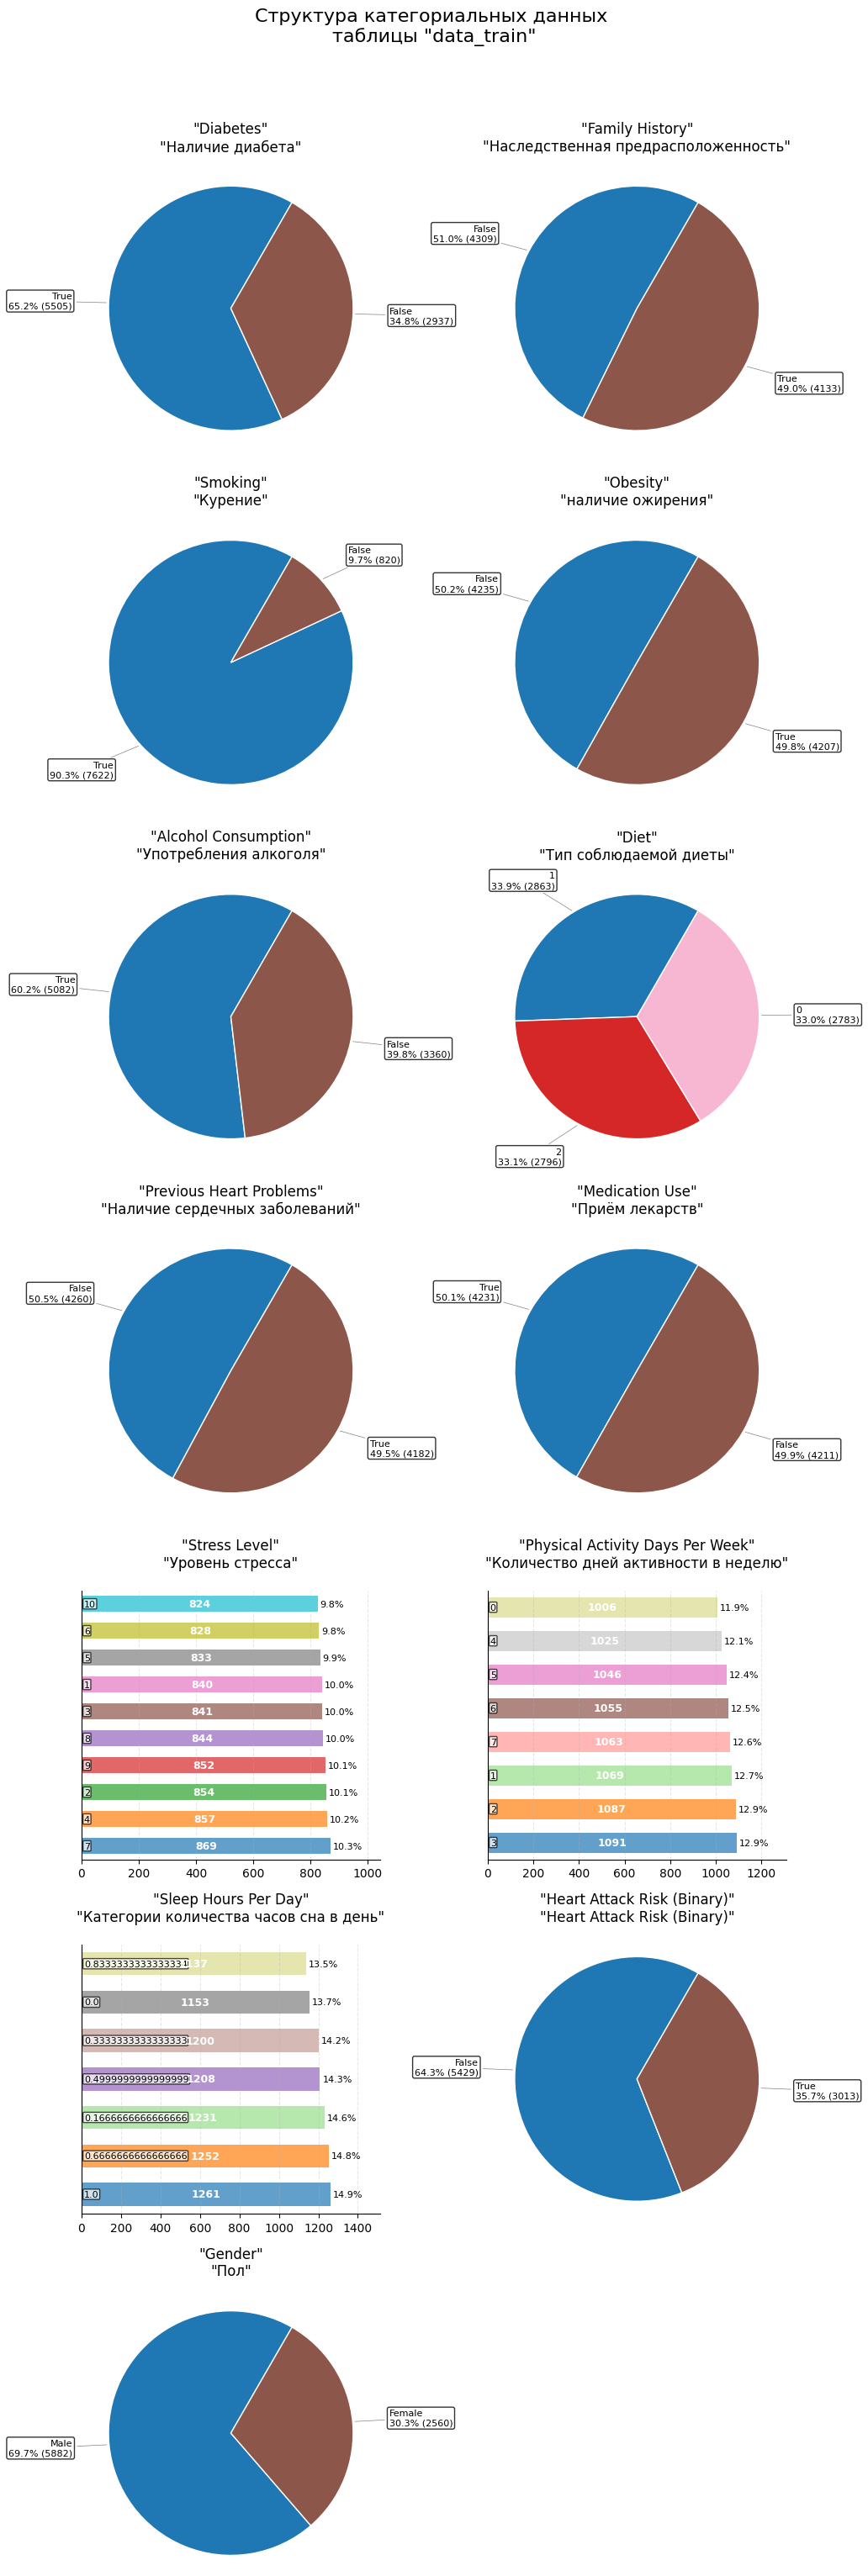

In [65]:
create_charts(data_to_plot, 'data_train', figsize=(10, 30), start_angle = 60)

#### Выводы

---

**Анализ категориальных данных**

**1. Общая характеристика целевой переменной - `heart_attack_risk`**

Целевая переменная `heart_attack_risk` (риск поражения сердца) распределена следующим образом:
- **64,3%** (5 429 наблюдений) — высокий риск поражения сердца;
- **35,7%** (3 013 наблюдений) — низкий риск.

Это указывает на **несбалансированность выборки** в сторону повышенного риска, что может повлиять на обучение моделей машинного обучения Данный факт необходимо учесть и применять методы балансировки).

**2. Анализ факторов, потенциально влияющих на риск поражения сердца**

- **`diabetes` (наличие диабета)**: 65,2% (5505 чел.) имеют диабет. Существует дисбаланс. Так как это значимый фактор риска (диабет напрямую связан с сердечно-сосудистыми заболеваниями) то  дисбаланс может негативно влиять на качество предсказаний модели для группы без диабета
- **`family_history` (наследственная предрасположенность)**: 49% (4 133) имеют семейную историю сердечно-сосудистых заболеваний. Генетический фактор играет важную роль. Данные данного параметра сбалансированы.
- **`obesity` (наличие ожирения)**: 50,2% (4235 чел.) страдают ожирением.  Данные данного параметра сбалансированы.
- **`previous_heart_problems` (наличие сердечных заболеваний)**: почти равное распределение (50,5% против 49,5%)
- **`smoking` (курение)**: только 9,7% (820) не курят. Анализ показывает серьёзный дисбаланс. модель может игнорировать класс «не курит», фокусируясь на большинстве. Необходимо использовать модели и методы, учитывающие вес классов
- **`alcohol_consumption` (употребление алкоголя)**: 39,8% (3 360)  не употребляют алкоголь. Умеренное употребление может быть защитным фактором, но избыточное — увеличивает риск. Данные несбалансированы
- **`diet` (тип соблюдаемой диеты)**: три категории примерно равны (по ~33%)
- **`physical_activity_days_per_week` (количество дней активности в неделю)**: данные категории сбалансированы. почти все показатели представлены в равных пропорциях.
- **`stress_level` (уровень стресса)**: уровни стресса распределены относительно равномерно (от 9,8% до 10,3%). Хронический стресс — значимый фактор риска, требующий качественного анализа.
- **`sleep_hours_per_day_cat` (количество часов сна в день)**: (данные были нормализованы) распределение показывает, что большинство спят много, но есть значительная доля с отклонениями, что может коррелировать с риском.  
Данные сбалансированы
- **`gender` (пол)**: мужчины составляют 69,7% (5 882), женщины — 30,3% (2 560). Данные имеют сильный дисбаланс.
- **«medication_use» (приём лекарств)**: почти равное распределение (50,1% против 49,9%).


**3. Потенциальные проблемы для моделирования**

- Несбалансированность целевой переменной (64,3% против 35,7%).
- Неравномерность некоторых факторов (например, курение, употребление алкоголя, наличие диабета и пр.), что может затруднить обучение моделей.


**4. Для построения эффективной прогностической модели рекомендуется:**
-  Применить методы балансировки классов (SMOTE, взвешивание).
-  Провести корреляционный анализ между факторами.
-  Учесть нелинейные зависимости и взаимодействия переменных.
-  Использовать кросс-валидацию и метрики, устойчивые к несбалансированности (F1-score, ROC-AUC).

## Корреляционный анализ

In [66]:
def phik_matrix_analyze(data, num_cols=None, cat_cols=None , title=None, visualisation=True, n_separator=7, figsize=(14, 14)):
    
    def separator(n=n_separator):
        print('='*n)
        print()
    
    if title:
        print('Анализ матрицы корреляций phik для ' + title)
        separator()
    else:
        print('Анализ матрицы корреляций phik:')
        separator()

    print('')

    df = data.copy()

    # Преобразуем категориальные колонки в тип 'category'
    if cat_cols is not None:
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')
            else:
                print(f'Колонка {col} не найдена в данных')

    # Убедимся, что числовые колонки имеют числовой тип
    if num_cols is not None:
        for col in num_cols:
            if col in df.columns:
                # Попробуем преобразовать к числовому типу, если возможно
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                print(f'Колонка {col} не найдена в данных')

    # Теперь все колонки в cat_cols имеют тип category, а в num_cols - числовой тип

    # Объединяем все колонки, которые будем использовать
    all_cols = []
    if num_cols is not None:
        all_cols += num_cols
    if cat_cols is not None:
        all_cols += cat_cols

    # Убедимся, что все колонки присутствуют в df
    all_cols = [col for col in all_cols if col in df.columns]

    # Вычисляем матрицу phik
    phik_corr = phik_matrix(
            df[all_cols], 
            interval_cols=num_cols  # передаем только числовые колонки как интервальные
    )

    print('Матрица корреляций phik:')
    display(phik_corr.round(4))

    if visualisation:
        # График матрицы корреляции
        plt.figure(figsize=figsize)
        sns.heatmap(
                    phik_corr, 
                    annot=True, 
                    cmap='PuOr', 
                    center=0, 
                    square=True, 
                    fmt='.3f', 
                    cbar_kws={"shrink": .8}
                    )
        plt.title(rf'Матрица корреляций $\phi_K$ для {title}' if title else r'Матрица корреляций $\phi_K$', 
           fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

In [67]:
num_cols = [
    'Age', 
    'Cholesterol', 
    'Exercise Hours Per Week', 
    'Sedentary Hours Per Day',
    'Income', 'BMI', 'Triglycerides', 'Blood sugar', 
    'Systolic blood pressure', 'Diastolic blood pressure',
    'Heart rate'
    ]

In [68]:
cat_cols

['Diabetes',
 'Family History',
 'Smoking',
 'Obesity',
 'Alcohol Consumption',
 'Diet',
 'Previous Heart Problems',
 'Medication Use',
 'Stress Level',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day',
 'Heart Attack Risk (Binary)',
 'Gender']

In [69]:
data=data_train.copy()

Анализ матрицы корреляций phik для Трениовочная выборка


Матрица корреляций phik:


,Age,Cholesterol,Exercise Hours Per Week,Sedentary Hours Per Day,Income,BMI,Triglycerides,Blood sugar,Systolic blood pressure,Diastolic blood pressure,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Diet,Previous Heart Problems,Medication Use,Stress Level,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Gender
Age,1.0000,0.0473,0.0000,0.0301,0.0000,0.0200,0.0599,0.3595,0.0335,0.0390,0.0965,0.0372,0.0000,0.6205,0.0000,0.0000,0.0380,0.0000,0.0126,0.0525,0.0108,0.0273,0.0222,0.0000
Cholesterol,0.0473,1.0000,0.0584,0.0507,0.0379,0.0164,0.0674,0.0000,0.0504,0.0465,0.0468,0.0337,0.0000,0.0252,0.0000,0.0514,0.0000,0.0000,0.0000,0.0534,0.0109,0.0304,0.0000,0.0298
Exercise Hours Per Week,0.0000,0.0584,1.0000,0.0525,0.0835,0.0285,0.0588,0.0077,0.0344,0.0523,0.0000,0.0000,0.0000,0.0084,0.0570,0.0000,0.0209,0.0314,0.0000,0.0585,0.0154,0.0298,0.0000,0.0313
Sedentary Hours Per Day,0.0301,0.0507,0.0525,1.0000,0.0000,0.0297,0.0000,0.0000,0.0000,0.0550,0.0670,0.0362,0.0117,0.0102,0.0281,0.0539,0.0000,0.0311,0.0353,0.0318,0.0131,0.0532,0.0199,0.0000
Income,0.0000,0.0379,0.0835,0.0000,1.0000,0.0761,0.0698,0.0000,0.0480,0.0477,0.0618,0.0063,0.0332,0.0000,0.0000,0.0280,0.0000,0.0000,0.0000,0.0213,0.0374,0.0328,0.0123,0.0072
BMI,0.0200,0.0164,0.0285,0.0297,0.0761,1.0000,0.0000,0.0000,0.0000,0.0595,0.0475,0.0101,0.0186,0.0108,0.0000,0.0109,0.0067,0.0370,0.0138,0.0823,0.0430,0.0396,0.0000,0.0411
Triglycerides,0.0599,0.0674,0.0588,0.0000,0.0698,0.0000,1.0000,0.0452,0.0000,0.0434,0.0000,0.0432,0.0000,0.0349,0.0059,0.0250,0.0449,0.0000,0.0000,0.0488,0.0000,0.0277,0.0000,0.0582
Blood sugar,0.3595,0.0000,0.0077,0.0000,0.0000,0.0000,0.0452,1.0000,0.0290,0.0000,0.3582,0.0000,0.0279,0.1156,0.0000,0.0000,0.0463,0.0000,0.0000,0.0000,0.0261,0.0240,0.0000,0.0000
Systolic blood pressure,0.0335,0.0504,0.0344,0.0000,0.0480,0.0000,0.0000,0.0290,1.0000,0.0431,0.0393,0.0387,0.0303,0.0000,0.0314,0.0000,0.0319,0.0000,0.0097,0.0516,0.0000,0.0000,0.0325,0.0155
Diastolic blood pressure,0.0390,0.0465,0.0523,0.0550,0.0477,0.0595,0.0434,0.0000,0.0431,1.0000,0.0447,0.0262,0.0244,0.0000,0.0491,0.0000,0.0000,0.0443,0.0000,0.0465,0.0480,0.0147,0.0000,0.0050


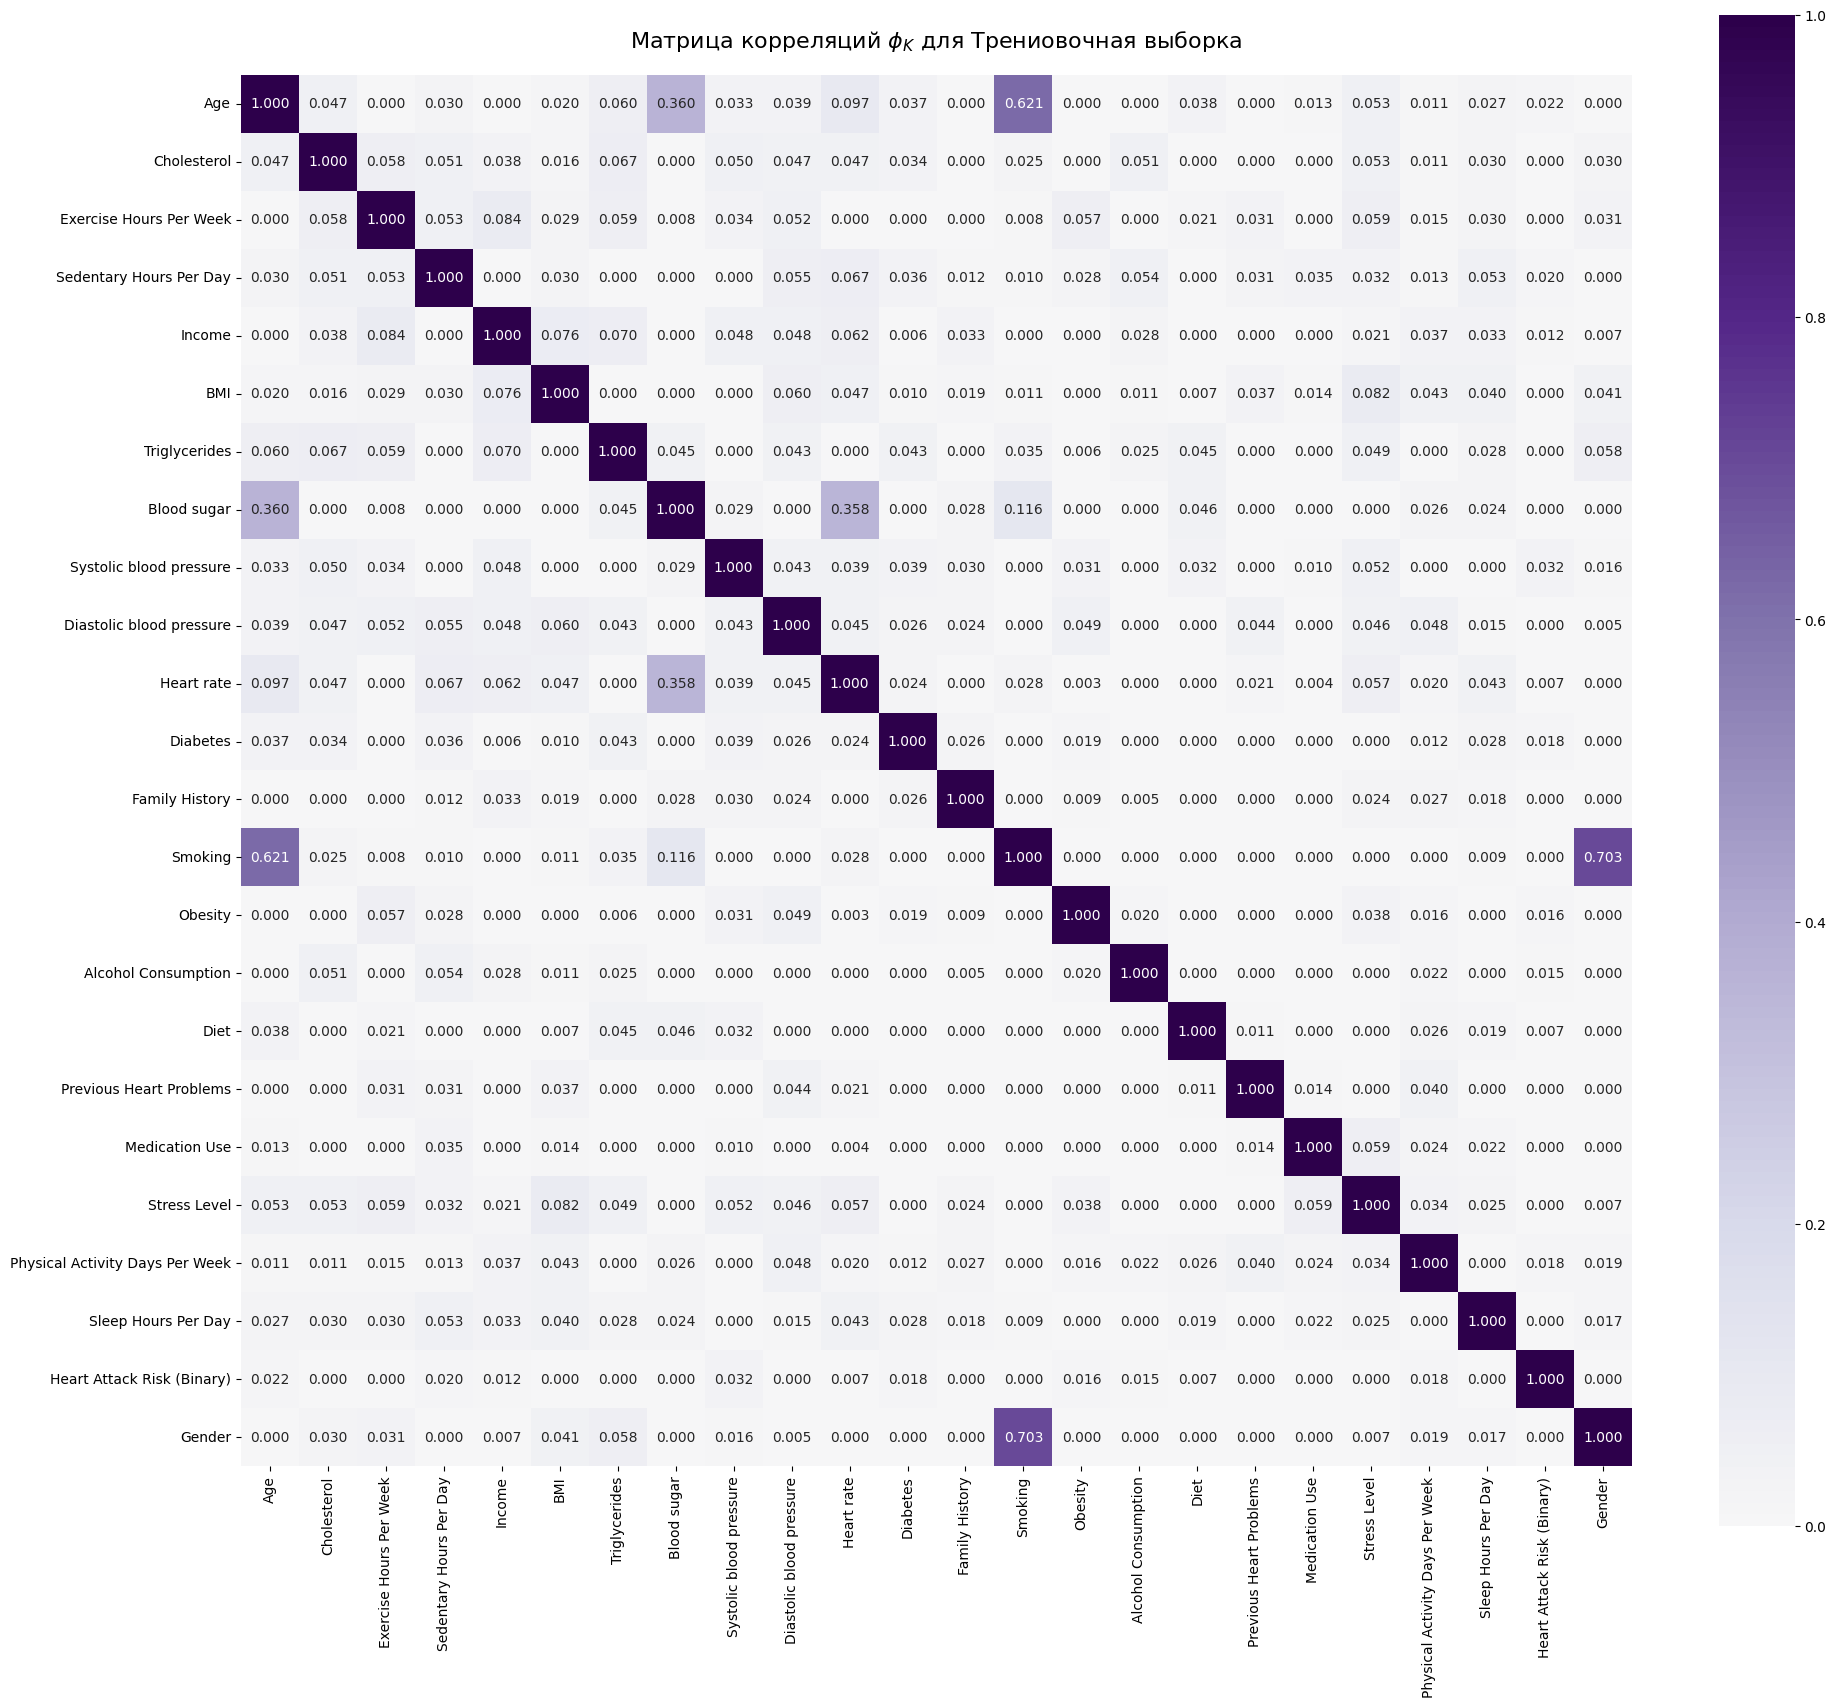

In [70]:
phik_matrix_analyze(data.drop(columns=['id'], axis=1), 
                    num_cols=num_cols, cat_cols=cat_cols, 
                    title='Трениовочная выборка', visualisation=True, figsize=(20, 20))

### Выводы 


1. Сильные корреляции (>0.5)
**С целевой переменной:** Отсутствуют. Максимальная корреляция = 0.0325 (систолическое давление)

**Между предикторами:**
- `smoking ↔ gender` (0.703) — критическая мультиколлинеарность
- `age ↔ smoking` (0.621) — возраст и курение взаимосвязаны
- `age ↔ blood_sugar` (0.360) + `heart_rate_balanced ↔ blood_sugar` (0.358) — метаболический кластер


2. Мультиколлинеарность
**Проблемная группа:** `smoking` и `gender` (r=0.703) — почти дублируют друг друга.

**Решение:** Удалить `smoking`, так как:
- информация о поле косвенно содержится в `gender`
- `smoking` имеет сильный дисбаланс

**Возраст** `age` коррелирует с `blood_sugar` и `heart_rate_balanced` — отражает естественное ухудшение метаболизма.

5. Факторы риска для `heart_attack_risk`
**Прямое влияние:**
1. Систолическое давлени `systolic_blood_pressure` (r=0.0325)
2. Возраст `age` (r=0.022)
3. часы сидячего образа жизни в день - `sedentary_hours_per_day` (r=0.02)
3. Диабет `diabetes` - (r=0.0183)
4. Ожирение `obesity` (r=0.0158)

**Вывод:** Риск определяется **комбинацией слабых факторов**, а не единым предиктором.

6. Рекомендации для модели
**Отбор признаков:**
- **Исключить:** `smoking` (из-за коллинеарности с `gender`) а так же по причине критического дисбаланса
- **Сохранить:** все остальные признаки, включая слабые корреляции

**Рассмотреть создание новых признаков**
   - `age * blood_sugar / 100` (индекс метаболического возраста)
   - `bmi * diastolic_blood_pressure / 100` (кардиометаболическая нагрузка)
   - `exercise_hours / (sedentary_hours + 1)` (баланс активности)


**Выбор алгоритма:**
- **Отказ от линейных моделей** (логистическая регрессия) — неэффективны при слабых линейных связях
- **Использовать ансамблевые модели:** Gradient Boosting, Random Forest, XGBoost — лучше понимает нелинейности и взаимодействия
- **Использовать кросс-валидацию** 5-10 фолдов

### Создание новых признаков

In [71]:
# metabolic age index (mai) - индекс метаболического возраста
data['mai'] = data['Age'] * data['Blood sugar'] / 100

In [72]:
# cardiometabolic load - кардиометаболическая нагрузка
data['cardiometabolic_load'] = data['BMI'] * data['Diastolic blood pressure'] / 100

In [73]:
col_to_remove = ['Diastolic blood pressure', 'BMI', 'Blood sugar']
temp_num_cols = [col for col in num_cols if col not in col_to_remove]

In [74]:
new_cols = ['mai', 'cardiometabolic_load']

In [75]:
temp_num_cols = temp_num_cols + new_cols

Анализ матрицы корреляций phik для Трениовочная выборка


Матрица корреляций phik:


,Age,Cholesterol,Exercise Hours Per Week,Sedentary Hours Per Day,Income,Triglycerides,Systolic blood pressure,Heart rate,mai,cardiometabolic_load,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Diet,Previous Heart Problems,Medication Use,Stress Level,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Gender
Age,1.0000,0.0473,0.0000,0.0301,0.0000,0.0599,0.0335,0.0965,0.7028,0.0583,0.0372,0.0000,0.6205,0.0000,0.0000,0.0380,0.0000,0.0126,0.0525,0.0108,0.0273,0.0222,0.0000
Cholesterol,0.0473,1.0000,0.0584,0.0507,0.0379,0.0674,0.0504,0.0468,0.0120,0.0634,0.0337,0.0000,0.0252,0.0000,0.0514,0.0000,0.0000,0.0000,0.0534,0.0109,0.0304,0.0000,0.0298
Exercise Hours Per Week,0.0000,0.0584,1.0000,0.0525,0.0835,0.0588,0.0344,0.0000,0.0000,0.0347,0.0000,0.0000,0.0084,0.0570,0.0000,0.0209,0.0314,0.0000,0.0585,0.0154,0.0298,0.0000,0.0313
Sedentary Hours Per Day,0.0301,0.0507,0.0525,1.0000,0.0000,0.0000,0.0000,0.0670,0.0000,0.0902,0.0362,0.0117,0.0102,0.0281,0.0539,0.0000,0.0311,0.0353,0.0318,0.0131,0.0532,0.0199,0.0000
Income,0.0000,0.0379,0.0835,0.0000,1.0000,0.0698,0.0480,0.0618,0.0000,0.0627,0.0063,0.0332,0.0000,0.0000,0.0280,0.0000,0.0000,0.0000,0.0213,0.0374,0.0328,0.0123,0.0072
Triglycerides,0.0599,0.0674,0.0588,0.0000,0.0698,1.0000,0.0000,0.0000,0.0200,0.0282,0.0432,0.0000,0.0349,0.0059,0.0250,0.0449,0.0000,0.0000,0.0488,0.0000,0.0277,0.0000,0.0582
Systolic blood pressure,0.0335,0.0504,0.0344,0.0000,0.0480,0.0000,1.0000,0.0393,0.0000,0.0576,0.0387,0.0303,0.0000,0.0314,0.0000,0.0319,0.0000,0.0097,0.0516,0.0000,0.0000,0.0325,0.0155
Heart rate,0.0965,0.0468,0.0000,0.0670,0.0618,0.0000,0.0393,1.0000,0.1176,0.0611,0.0239,0.0000,0.0279,0.0027,0.0000,0.0000,0.0213,0.0043,0.0572,0.0203,0.0433,0.0073,0.0000
mai,0.7028,0.0120,0.0000,0.0000,0.0000,0.0200,0.0000,0.1176,1.0000,0.0000,0.0225,0.0150,0.4128,0.0280,0.0000,0.0000,0.0000,0.0203,0.0394,0.0000,0.0000,0.0352,0.0035
cardiometabolic_load,0.0583,0.0634,0.0347,0.0902,0.0627,0.0282,0.0576,0.0611,0.0000,1.0000,0.0000,0.0000,0.0000,0.0049,0.0000,0.0257,0.0000,0.0000,0.0597,0.0442,0.0000,0.0343,0.0285


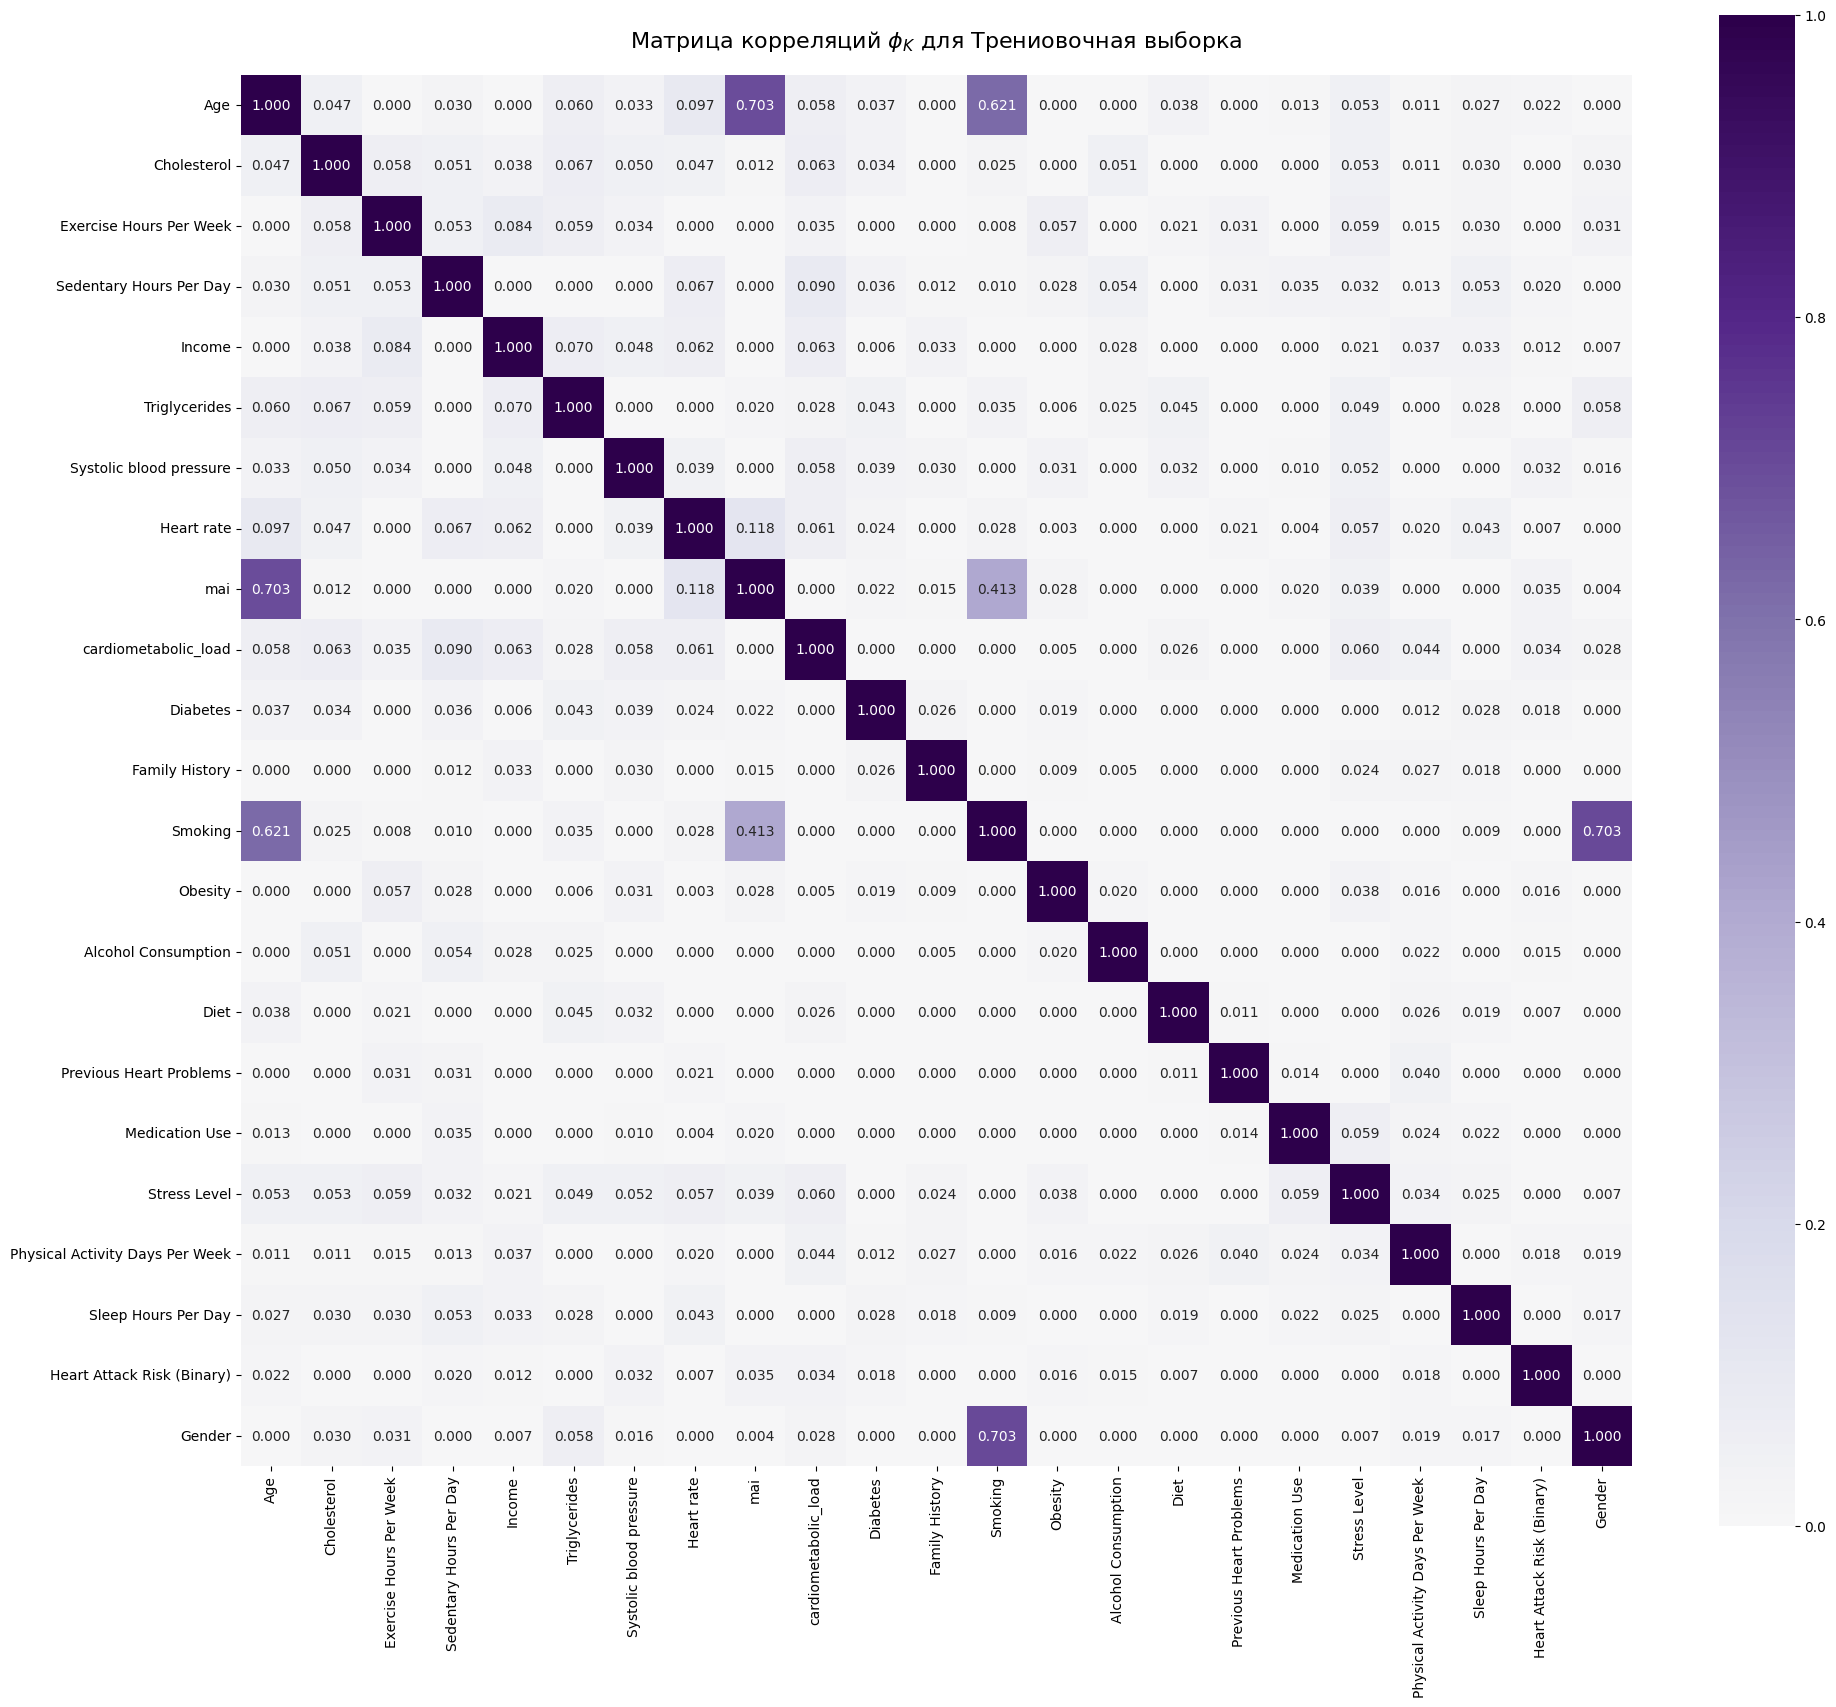

In [76]:
phik_matrix_analyze(data.drop(columns=['id', 'Diastolic blood pressure','Blood sugar'], axis=1), 
                    num_cols=temp_num_cols, cat_cols=cat_cols, 
                    title='Трениовочная выборка', visualisation=True, figsize=(20, 20))

### Выводы
Новые признаки незначительно но все же лучше коррелируют с целевой переменной, что позволяет улучшить качество будущей модели за счёт включения этих признаков в обучающий набор данных.

Новые признаки будут добавлены в данные при подготовке пайплайна

## Обучение и проверка модели

### Подготовка данных

In [77]:
try:
    data = load_data('heart_train.csv', decimal='.')
    show_data(data_train)
except Exception as e:
    print(f'Ошибка {e}')



Файл успешно загружен из: data/heart_train.csv

Общая информация о датасете
Количество строк: 8442
Количество столбцов: 28

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8442 non-null   int64  
 1   Age                              8442 non-null   float64
 2   Cholesterol                      8442 non-null   float64
 3   Heart rate                       8442 non-null   float64
 4   Diabetes                         8442 non-null   bool   
 5   Family History                   8442 non-null   bool   
 6   Smoking                          8442 non-null   bool   
 7   Obesity                          8442 non-null   bool   
 8   Alcohol Consumption              8442 non-null   bool   
 9   Exercise Hours Per Week          8442 non-null   float64
 10  Di

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,True,True,True,True,True,0.535505,1,True,False,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,False,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,True,True,False,False,True,0.068690,2,True,False,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,False,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,True,False,True,True,True,0.944001,2,True,True,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,False,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,False,False,True,False,True,0.697023,0,False,True,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,True,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,False,False,True,False,True,0.412878,1,False,False,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,True,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [78]:
initial_rows = len(data)
data = data.dropna()
print(f'Удалено {initial_rows - len(data)} строк с пропусками')

Удалено 243 строк с пропусками


In [79]:
drop_cols = ['id', 'Unnamed: 0', 'CK-MB', 'Troponin']
trget_col = ['Heart Attack Risk (Binary)']

In [80]:
X = data.drop(drop_cols + trget_col, axis=1)
y = data[trget_col]

In [81]:
ohe_cat_cols = ['Diabetes', 'Family History', 'Obesity', 'Smoking', 'Alcohol Consumption',
           'Previous Heart Problems', 'Medication Use', 'Gender', 'Diet']


ord_cat_cols = ['Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day']


num_cols = ['Age', 'Blood sugar', 'BMI', 'Cholesterol', 'Exercise Hours Per Week',
           'Sedentary Hours Per Day', 'Income', 'Triglycerides', 
           'Systolic blood pressure', 'Diastolic blood pressure', 'Heart rate']




In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [ ]:
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False
    ))
]).set_output(transform="pandas")

# Для порядковых признаков
ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        dtype=np.int64
    ))
]).set_output(transform="pandas")

# Для числовых колонок
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
]).set_output(transform="pandas")

# общий препроцессор
preprocessor = ColumnTransformer([
    ('ohe_cat', ohe_pipe, ohe_cat_cols),
    ('ord_cat', ord_pipe, ord_cat_cols),
    ('num', num_pipe, num_cols)
], remainder='drop')

In [ ]:
class_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        estimator=XGBClassifier(random_state=RANDOM_STATE), 
        threshold='median',  
        max_features=None,
        prefit=False
    )),
    ('model', DummyClassifier(random_state=RANDOM_STATE)) 
])

In [ ]:
# проверка списка колонок после удаления
print("Колонки в X_train:", X_train.columns.tolist())

# пробуем обучить препроцессор
try:
    preprocessor.fit(X_train)
    X_preprocessed = preprocessor.transform(X_train)
    print('Преобразование успешно. Форма:', X_preprocessed.shape)
except Exception as e:
    print('Ошибка в препроцессоре:', e)

Колонки в X_train: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure']
Преобразование успешно. Форма: (6331, 24)


### Сетки для подбора параметров моделей

In [ ]:
param_grid = [
    # DummyClassifier (Проверка на целесообразность)
    {
        'model': [DummyClassifier(random_state=RANDOM_STATE)],
        'model__strategy': ['most_frequent', 'stratified', 'uniform']
    },
    
    {
        'model': [XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_jobs=-1,
            verbosity=0
        )],
        'feature_selection__threshold': ['median', '0.5*median', 'mean'],
        'feature_selection__max_features': [15, 20, None],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.7, 0.8, 0.9],
        'model__colsample_bytree': [0.7, 0.8, 1.0],
        'model__reg_alpha': [0, 0.1, 1],
        'model__reg_lambda': [1, 10],
        'model__scale_pos_weight': [1, 3, 5],
    },

    {
        'model': [LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            boosting_type='gbdt'
        )],
        'feature_selection__threshold': ['median', 'mean'],
        'feature_selection__max_features': [None, 15, 20],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__num_leaves': [31, 63],
        'model__max_depth': [5, 10, -1],
        'model__subsample': [0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 1.0],
        'model__reg_alpha': [0, 0.1],
        'model__reg_lambda': [0, 0.1],
        'model__is_unbalance': [True, False],
    },

    {
        'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'feature_selection__threshold': ['median', 'mean'],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__max_features': ['sqrt', 'log2', None],
    },

    {
        'model': [BalancedRandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1
        )],
        'feature_selection__threshold': ['median', 'mean'],
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2'],
        'model__bootstrap': [True, False],
        'model__class_weight': ['balanced', 'balanced_subsample'],
        'model__sampling_strategy': ['auto', 'all'],
    }
]

In [89]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [90]:
rs = RandomizedSearchCV(
    estimator=class_pipe,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)

In [91]:
rs.fit(X_train, y_train)

display('Лучшая модель и её параметры:', rs.best_estimator_)
display(f'Метрика лучшей модели на кросс-валидации выборке: {rs.best_score_:.4f}')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


'Лучшая модель и её параметры:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Diabetes', 'Family History',
                                                   'Obesity', 'Smoking',
                                                   'Alcohol Consumption',
                                                   'Previous Heart Problems',
                                                   'Medication Use', 'Gender',
                                                   'Diet']),
                                                 ('ord_cat',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(d...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

'Метрика лучшей модели на кросс-валидации выборке: 0.5305'

In [92]:
results_df = pd.DataFrame(rs.cv_results_)

In [93]:
results = pd.DataFrame(rs.cv_results_).sort_values('mean_test_score', ascending=False)
filter = ['rank_test_score','mean_test_score', 'std_test_score', 'param_model']
results[filter].head(20)

,rank_test_score,mean_test_score,std_test_score,param_model
8,1,0.5305,0.0045,"XGBClassifier(base_score=None, booster=None, c..."
67,2,0.5287,0.0108,"BalancedRandomForestClassifier(n_jobs=-1, rand..."
32,3,0.5278,0.0044,"XGBClassifier(base_score=None, booster=None, c..."
15,4,0.5274,0.0020,"XGBClassifier(base_score=None, booster=None, c..."
6,5,0.5269,0.0007,"XGBClassifier(base_score=None, booster=None, c..."
47,6,0.5267,0.0008,"XGBClassifier(base_score=None, booster=None, c..."
5,7,0.5266,0.0007,"XGBClassifier(base_score=None, booster=None, c..."
49,8,0.5265,0.0013,"XGBClassifier(base_score=None, booster=None, c..."
98,9,0.5265,0.0004,"XGBClassifier(base_score=None, booster=None, c..."
28,10,0.5263,0.0005,"XGBClassifier(base_score=None, booster=None, c..."


In [94]:
f1_train = results.iloc[0]['mean_test_score']
f1_train

np.float64(0.5305032072757225)

#### Расчет ключевых метрик для лучшей модели на тестовых данных

In [95]:
best_classif_model = rs.best_estimator_
preprocessor_class = rs.best_estimator_.named_steps['preprocessor']
model_name = type(best_classif_model.named_steps['model']).__name__
best_classif_model.get_params()


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('ohe_cat',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['Diabetes', 'Family History', 'Obesity',
                                     'Smoking', 'Alcohol Consumption',
                                     'Previous Heart Problems', 'Medication Use',
                                     'Gender', 'Diet']),
                                   ('ord_cat',
                                    Pipeline(steps=[('ord',
                                                     OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                    handle...se_encoded_val

In [96]:
y_pred_classif_best = best_classif_model.predict(X_test)

In [97]:
def basic_statistics(y_test,y_pred):
    print(f"f1 = {f1_score(y_test,y_pred)}")
    print(f"recall = {recall_score(y_test,y_pred)}")
    print(f"precision = {precision_score(y_test, y_pred)}")
    print(f"accuracy = {accuracy_score(y_test,y_pred)}")

In [102]:
# расчет ключевых метрик на тестовой выборке для лучшей модели

f1_test = f1_score(y_test,y_pred_classif_best)

recall_test = recall_score(y_test,y_pred_classif_best)
precision_test = precision_score(y_test, y_pred_classif_best)
accuracy_test = accuracy_score(y_test,y_pred_classif_best)


print('Оценка лучшей модели')
separator()
print(f"Лучшая модель: {model_name}")
print(f'Лучшие параметры: {rs.best_params_}')
print(f'f1 на тренировочной выборке при кросс-валидации: {f1_train:.4f}')
print(f'f1 на валидационной выборке: {f1_test:.4f}')
print(f'recall = {recall_test}')
print(f'precision = {precision_test}')
print(f'accuracy = {accuracy_test}')


Оценка лучшей модели
Лучшая модель: XGBClassifier
Лучшие параметры: {'model__subsample': 0.9, 'model__scale_pos_weight': 5, 'model__reg_lambda': 10, 'model__reg_alpha': 0.1, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None,

### Выводы по результату подбора модели


**Лучшим алгоритмом** для решения задачи выбран XGBClassifier с подобранными параметрами.

**Регуляризация:** Установлены относительно высокие значения `reg_lambda` (10) и `reg_alpha` (0.1), что говорит о сильной L1 и L2 регуляризации для контроля сложности модели.

**Управление дисбалансом классов:** Параметр `scale_pos_weight = 5` был подобран для корректировки значимости положительного класса , что критически важно для метрик recall и precision.

**Структура ансамбля:** Использованы 100 деревьев (`n_estimators`) с глубиной 7 (`max_depth`) и умеренной скоростью обучения (`learning_rate = 0.05`), что является компромиссом между точностью и временем обучения.


### Анализ важности признаков

In [103]:
rf_model = rs.best_estimator_.named_steps['model']
preprocessor = rs.best_estimator_.named_steps['preprocessor']

In [104]:
feature_names = preprocessor.get_feature_names_out()

In [105]:
X_test_transform = preprocessor.transform(X_test)
# Рассчитываем feature importances
perm_importance = permutation_importance(
    rf_model, X_test_transform, y_test,
    n_repeats=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [106]:
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance['importances_mean'],
    'Std': perm_importance['importances_std']
})

perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=True)


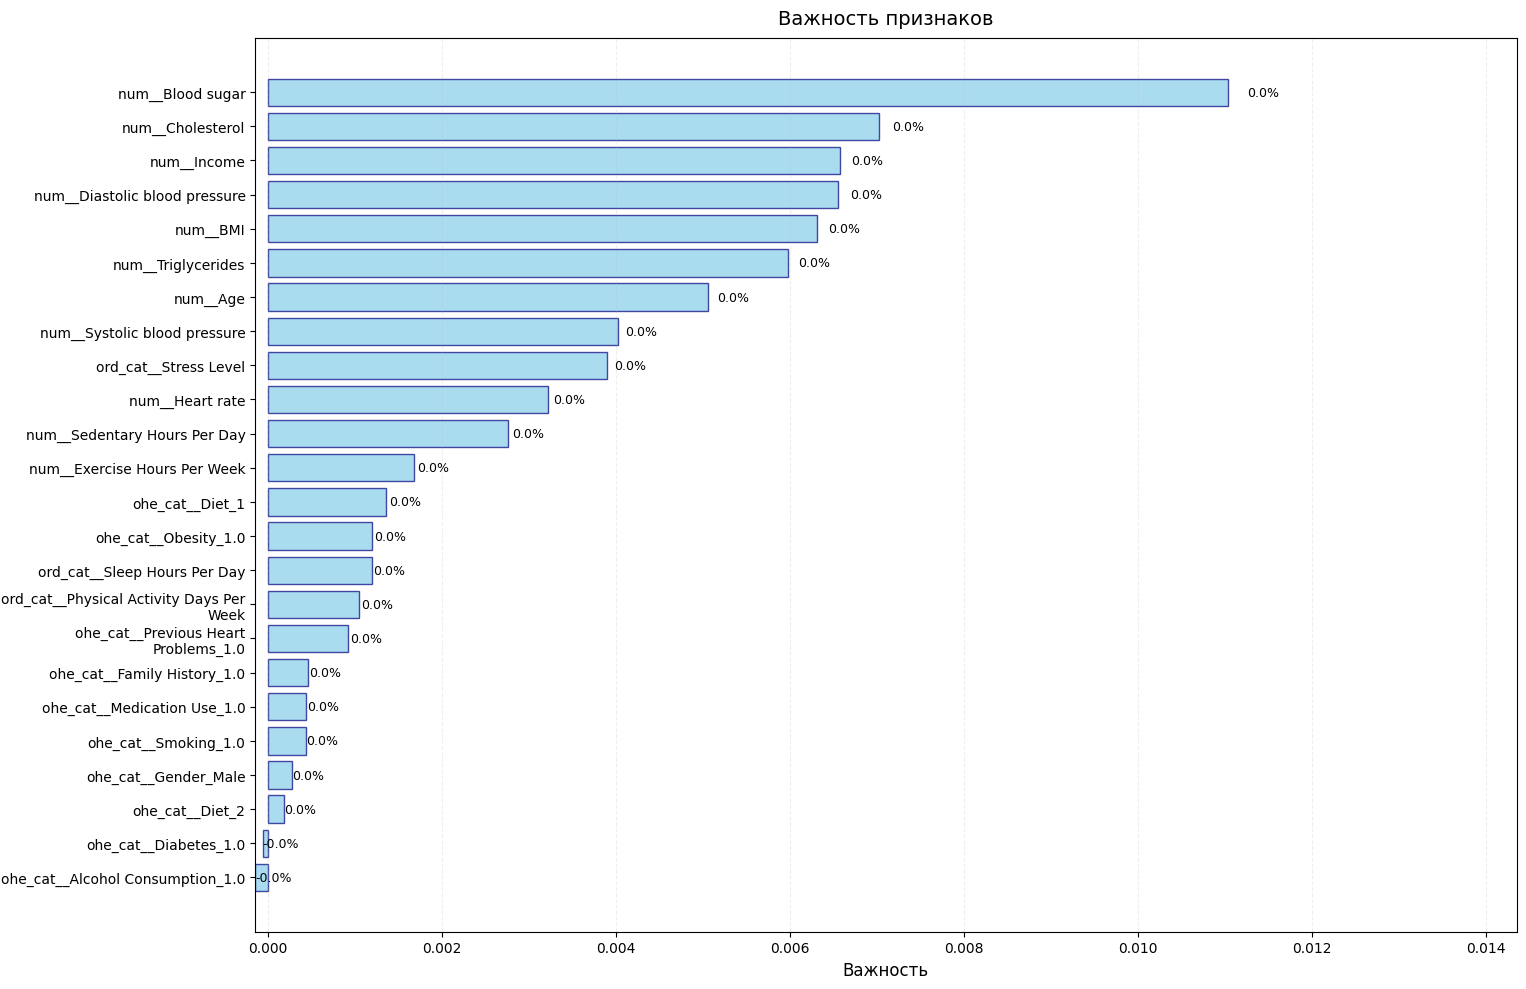

In [110]:
#Строим график с подписями
plt.figure(figsize=(15, 10))

bars = plt.barh(
    perm_importance_df['Feature'], 
    perm_importance_df['Importance'],
    color='skyblue',
    edgecolor='navy',
    alpha=0.7
)


for bar in bars:
    width = bar.get_width()

    plt.text(
        width * 1.02, 
        bar.get_y() + bar.get_height()/2,
        f'{width:.1f}%',
        ha='left',    
        va='center',   
        fontsize=9
    )

plt.title('Важность признаков', fontsize=14, pad=10)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.xticks(fontsize=10, wrap=True)
plt.yticks(fontsize=10, wrap=True)

# Настраиваем сетку
plt.grid(axis='x', alpha=0.2, linestyle='--')

plt.xlim(perm_importance_df['Importance'].min(), perm_importance_df['Importance'].max() * 1.3) 

plt.tight_layout()
plt.show()

### Анализ графика важности признаков

График показывает важность признаков, полученную методом `permutation importance` для обученной модели предсказания риска сердечного приступа. 
Все значения важности крайне низкие — максимум около 0.012, а большинство признаков имеют важность близкую к 0. Это критический сигнал, требующий тщательного разбора.
Подробные выводы по графику

Общий уровень важности признаков:
Все признаки имеют практически нулевую важность (от 0 до 0.012).
Самый «важный» признак — `Blood sugar` - 0.012, за ним следуют `Cholesterol`, `Income`, `Diastolic blood pressure` и `BMI` с важностью 0.010 или ниже.
Остальные признаки (включая клинически значимые, такие как возраст, уровень стресса, физическая активность, семейный анамнез, курение, диабет и т.д.) имеют важность 0% или близкую к нулю.

Клинически ожидаемые признаки имеют нулевую важность:
Факторы риска сердечно-сосудистых заболеваний (возраст, курение, семейный анамнез, диабет, артериальное давление, ожирение, уровень холестерина) в реальной медицине имеют высокую прогностическую ценность.
На графике же большинство из нихпоказывают 0% важности.
Это указывает на то, что модель практически не использует эти признаки для принятия решений.

### Анализ матрицы ошибок

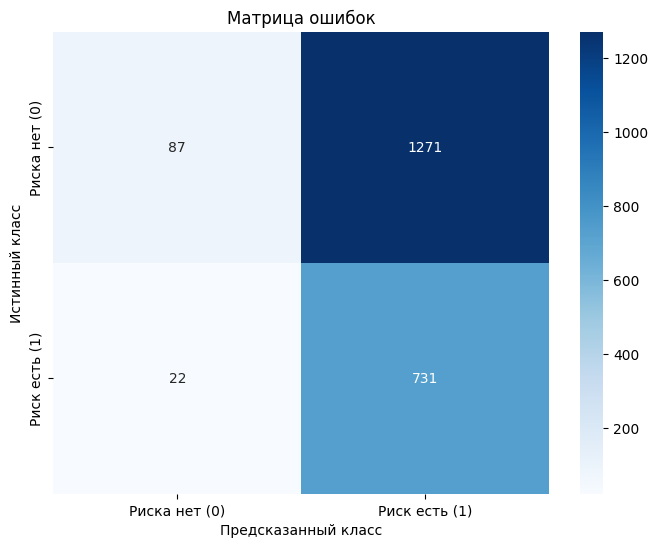

Количество пойманных клиентов с классом "Риск есть": 731
Количество пропущенных клиентов с классом "Риска нет": 22

Метрики:
Accuracy: 0.3875
Precision (для класса "Риск Есть"): 0.3651
Recall (для класса "Риск есть"): 0.9708
F2-score (для класса "Риск Есть"): 0.7290


In [113]:
cm = confusion_matrix(y_test, y_pred_classif_best) 

# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Риска нет (0)', 'Риск есть (1)'], 
            yticklabels=['Риска нет (0)', 'Риск есть (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'Количество пойманных клиентов с классом "Риск есть": {tp}')
print(f'Количество пропущенных клиентов с классом "Риска нет": {fn}')

# Расчет ключевых метрик
accuracy = accuracy_score(y_test,y_pred_classif_best)  
precision = precision_score(y_test,y_pred_classif_best) # Точность для класса 1
recall = recall_score(y_test,y_pred_classif_best)   # Полнота для класса 1


f2 =fbeta_score(y_test,y_pred_classif_best, beta=2, average='binary')   # F2 для класса 1

# Вывод результатов
print('\nМетрики:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (для класса "Риск Есть"): {precision:.4f}')
print(f'Recall (для класса "Риск есть"): {recall:.4f}')
print(f'F2-score (для класса "Риск Есть"): {f2:.4f}')

**Выводы**

1. **Качество модели низкое**  
   - Значение **F1‑score** на валидационной выборке (0.5307) лишь незначительно превышает результат на кросс‑валидации (0,5305), что говорит об отсутствии серьёзного переобучения.  
   - Однако сам уровень F1‑score указывает на низкое качество модели

2. **Крайне высокий recall при низкой precision**  
   - **Recall = 0,97** означает, что модель **находит почти все положительные случаи**.  
   - Однако **precision = 0,365** показывает, что лишь **36,5 % предсказанных положительных случаев являются истинными**. Это приводит к большому числу ложноположительных прогнозов. (Но при этом мы не упускаем истиные случаи риска, что в нашем случае имеет приоритет)

3. **Низкая общая точность (accuracy)**  
   - **Accuracy = 0,3875** (38,75 %) указывает, что модель правильно классифицирует менее 40 % всех объектов.  

4. **Рекомендации по улучшению**  
   - **Скорректировать баланс precision/recall**: если критично снизить число ложных срабатываний, стоит увеличить вес precision (например, через настройку порога классификации или использование `class_weight` с иными коэффициентами).  
   - Попробовать другие метрики:  AUC-ROC, F2‑score с акцентом на precision.  
   - Провести инжиниринг признаков для повышения корреляции с целевой переменной
  

Модель демонстрирует высокую полноту (recall), но низкую точность precision и  accuracy. Она подходит для сценариев, где критично не пропустить ни одного положительного случая (например, медицинская диагностика), но требует доработки, если важны корректность положительных прогнозов.

In [114]:
# Сохранение модели

joblib.dump(best_classif_model, "best_model2.pkl")

['best_model2.pkl']